Initialized analyzer for ETHUSD vs SOLUSD

Loading data for ETHUSD and SOLUSD...

Processing ETHUSD:
  2016: 53,297 valid observations
  2017: 103,702 valid observations
  2018: 105,009 valid observations
  2019: 105,067 valid observations
  2020: 105,301 valid observations
  2021: 105,109 valid observations
  2022: 105,119 valid observations
  2023: 105,057 valid observations
  2024: 105,383 valid observations
  2025: 65,843 valid observations
  Total observations: 958,887

Processing SOLUSD:
  2021: 56,817 valid observations
  2022: 105,119 valid observations
  2023: 105,052 valid observations
  2024: 105,367 valid observations
  2025: 65,869 valid observations
  Total observations: 438,224

Creating multi-timeframe datasets...
     1H: ETHUSD=80,870 obs, SOLUSD=36,526 obs
     4H: ETHUSD=20,236 obs, SOLUSD=9,133 obs
    12H: ETHUSD=6,747 obs, SOLUSD=3,045 obs
     1D: ETHUSD=3,374 obs, SOLUSD=1,523 obs
     3D: ETHUSD=1,125 obs, SOLUSD=508 obs

VOLUME-ENHANCED COINTEGRATION ANALYSIS

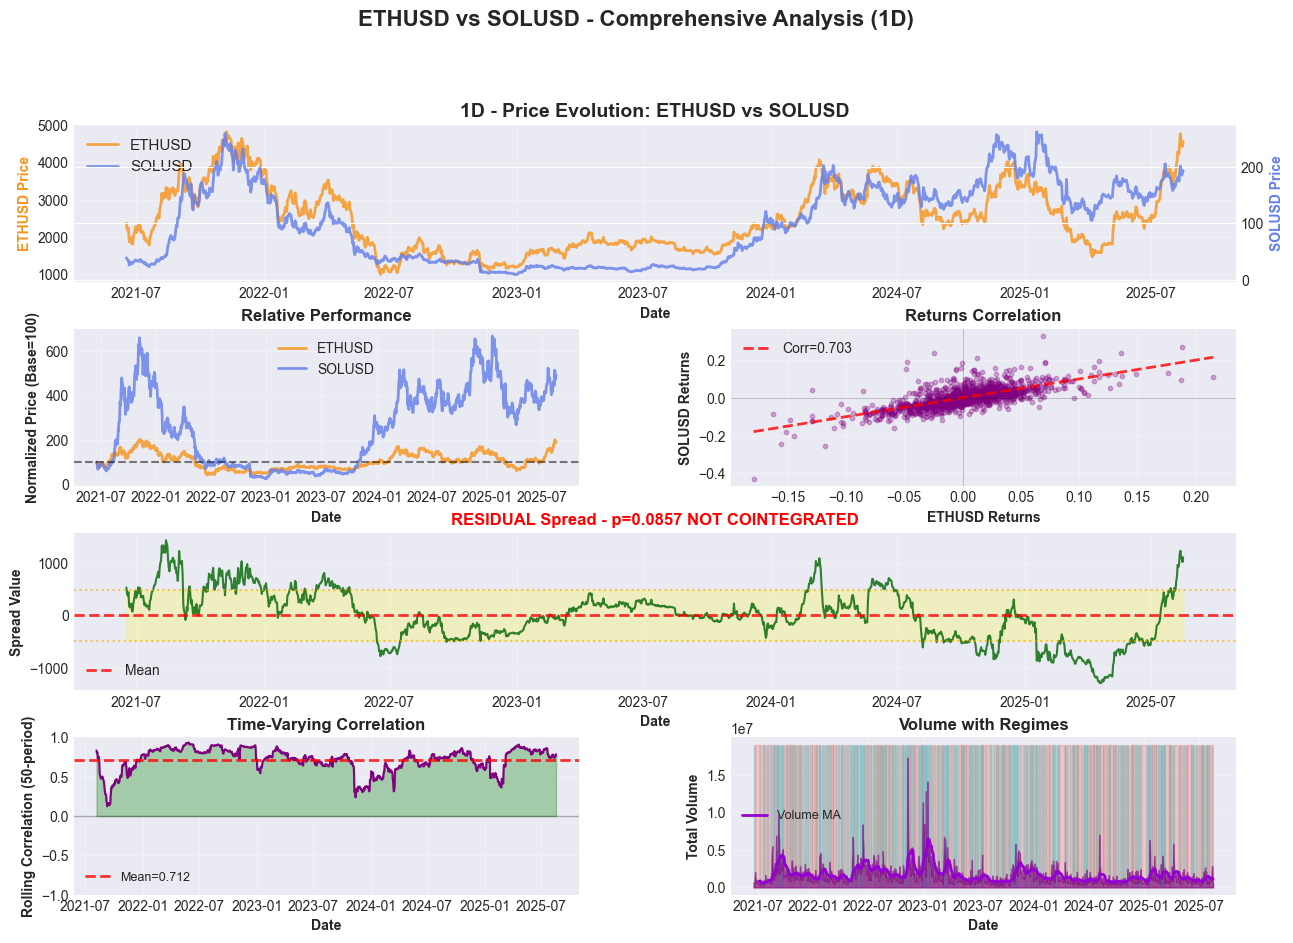


2. Spread Analysis...


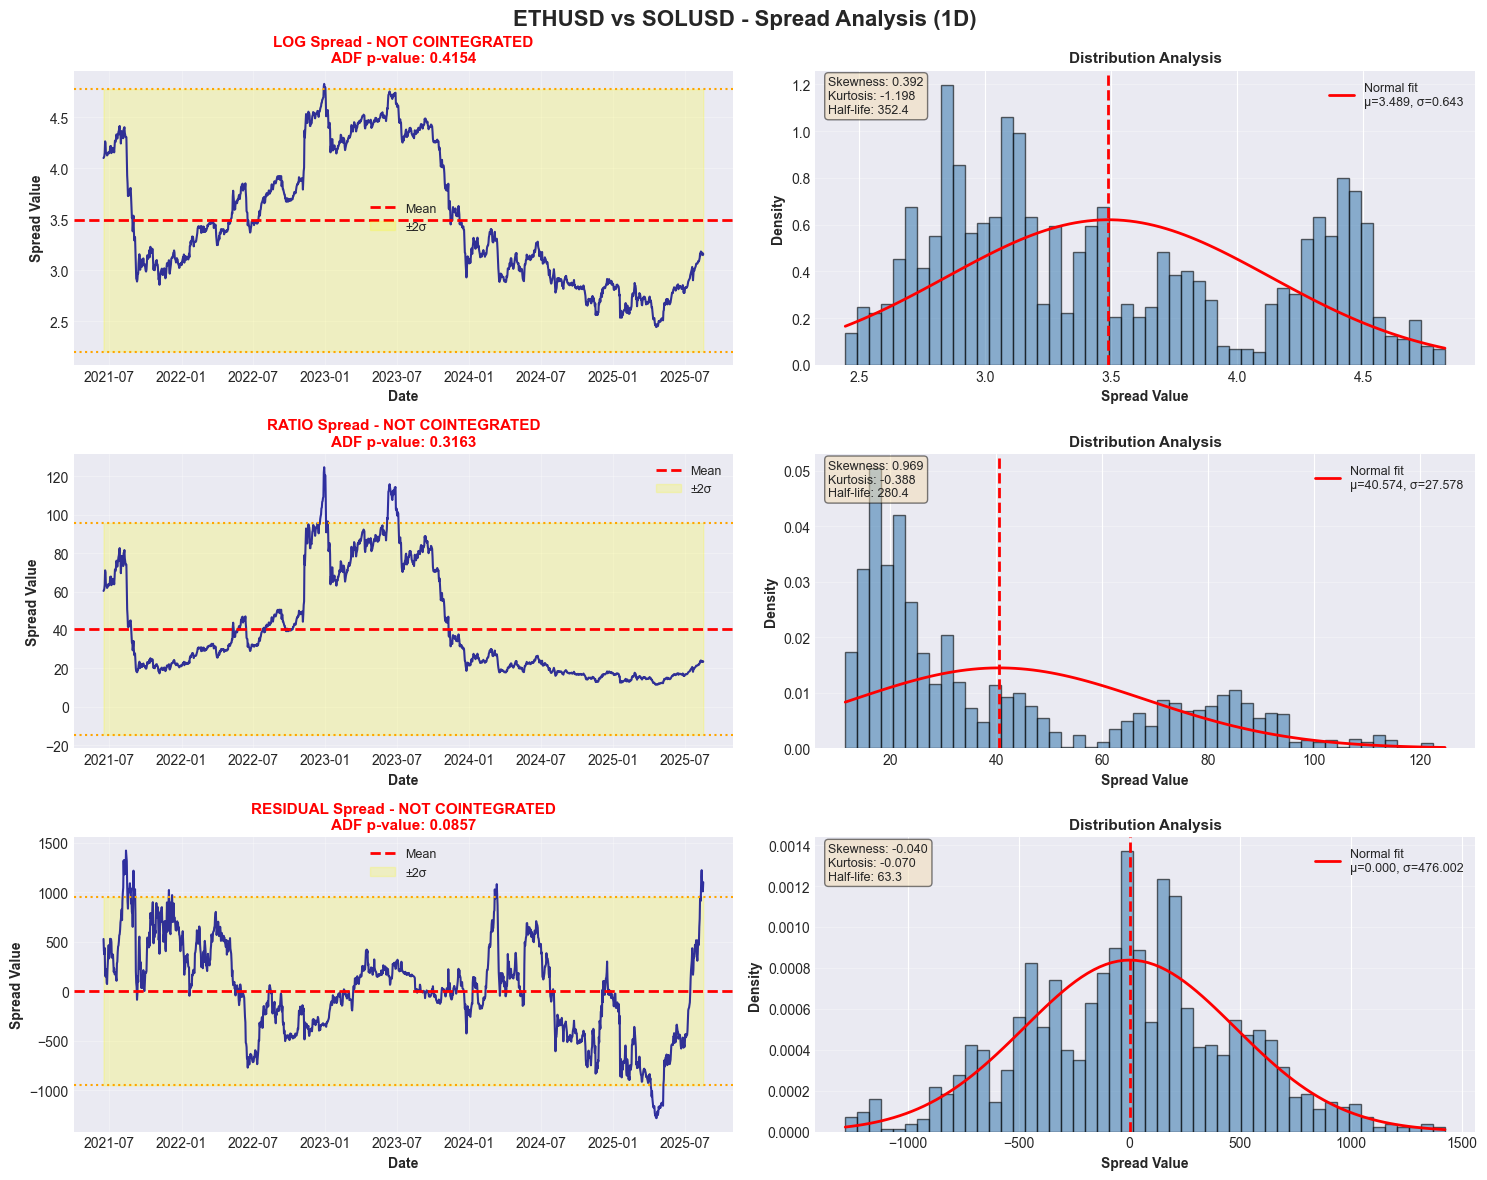


3. Cointegration Heatmap...


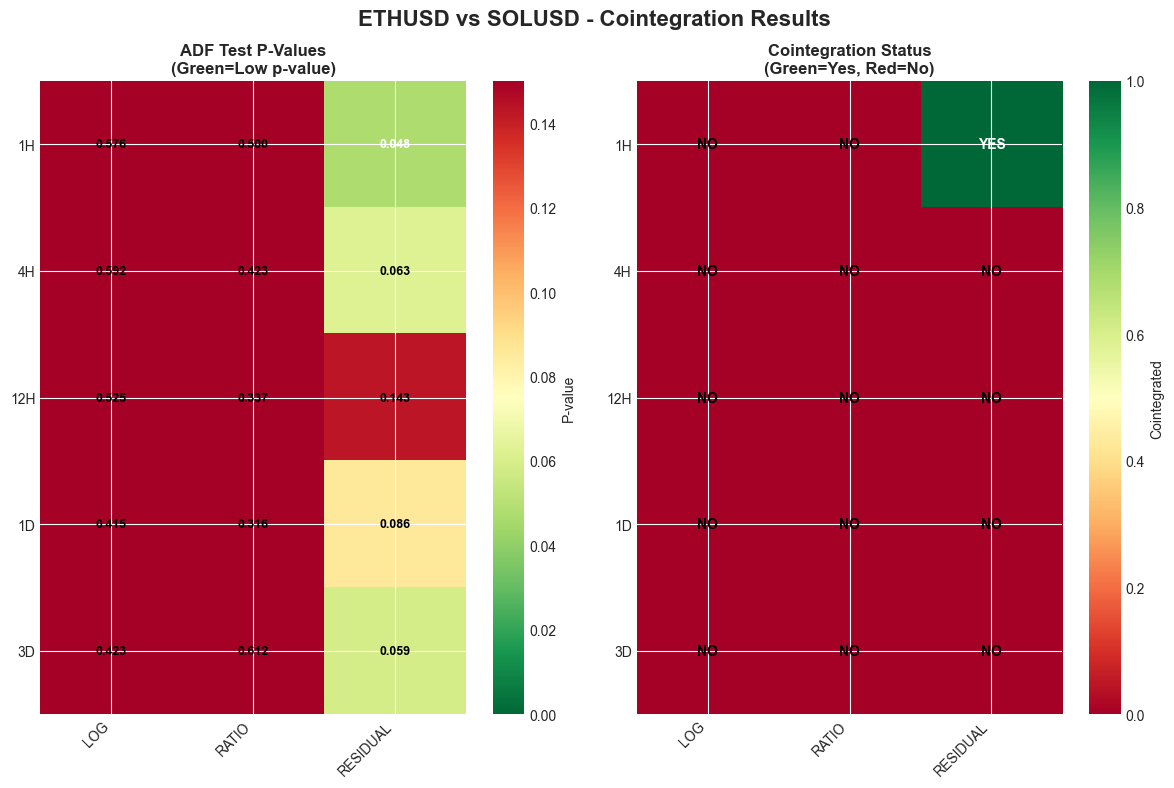


4. Volume Regime Analysis...


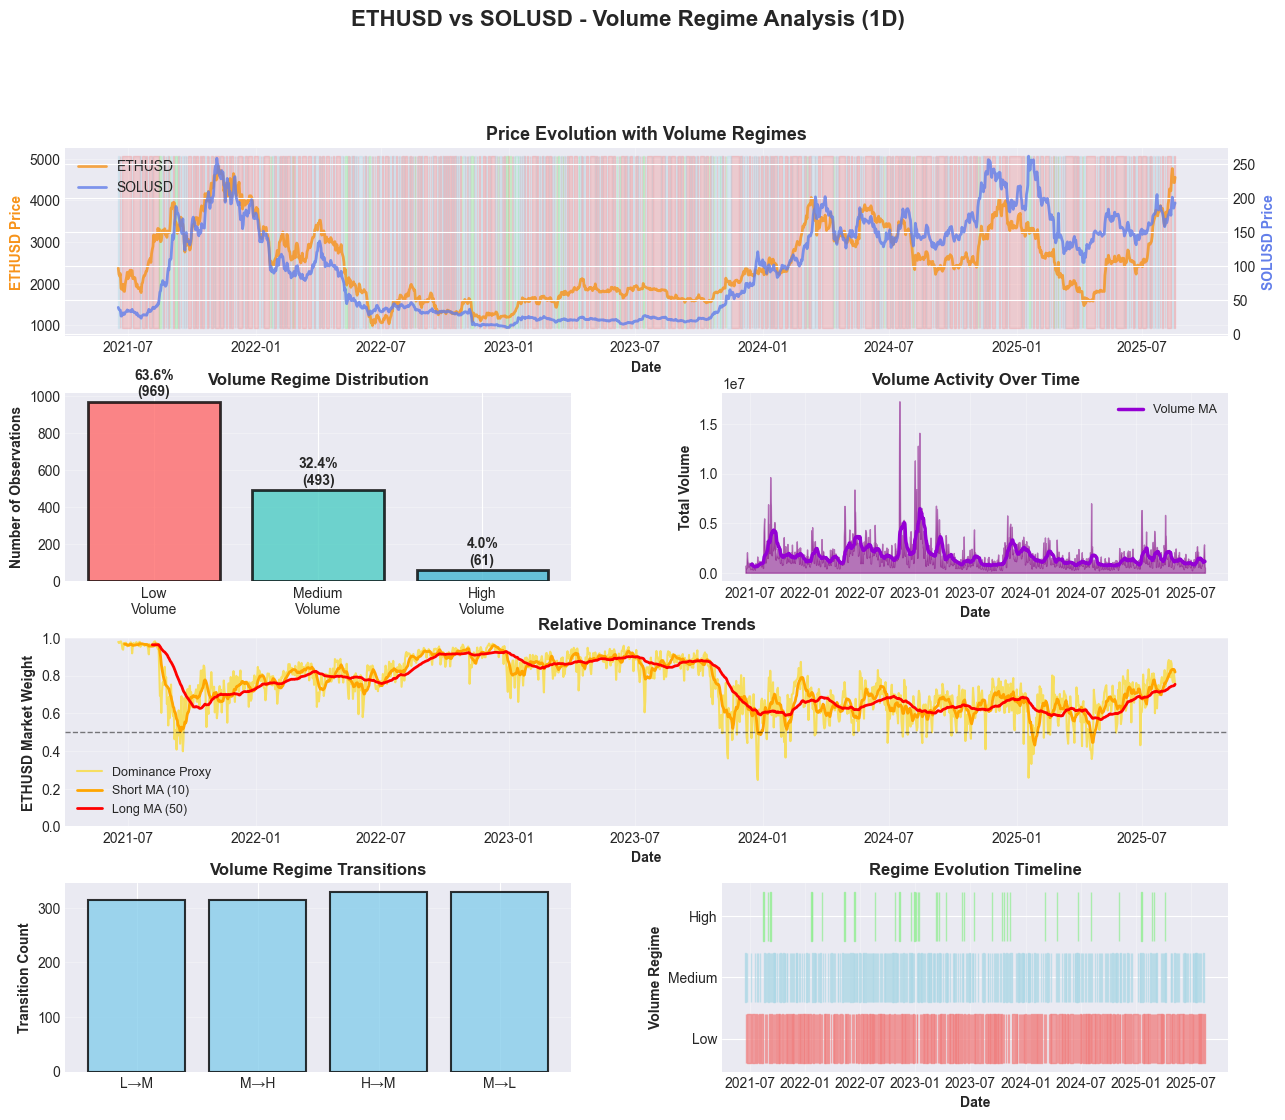


All visualizations complete!


In [1]:
"""
Generalized Volume-Enhanced Cryptocurrency Cointegration Analysis
Analyzes cointegration between any two cryptocurrency pairs with volume regime detection
"""

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


class CryptoCointegrationAnalyzer:
    """
    Generalized cointegration analyzer for any two cryptocurrency pairs.
    """
    
    def __init__(self, symbol1, symbol2, data_dir="coinbase/5m"):
        """
        Initialize analyzer with two crypto symbols.
        
        Parameters:
        -----------
        symbol1, symbol2 : str
            Cryptocurrency symbols (e.g., 'BTCUSD', 'ETHUSD')
        data_dir : str or Path
            Directory containing historical data
        """
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.data_dir = Path(data_dir)
        self.data = {}
        self.results = {}
        
        print(f"Initialized analyzer for {symbol1} vs {symbol2}")
    
    def load_data(self):
        """Load and prepare data for both symbols."""
        print(f"\nLoading data for {self.symbol1} and {self.symbol2}...")
        
        csv_columns = ["timestamp", "open", "high", "low", "close", "volume"]
        
        for symbol in [self.symbol1, self.symbol2]:
            print(f"\nProcessing {symbol}:")
            yearly_dfs = []
            
            for year_dir in sorted(self.data_dir.iterdir()):
                if not year_dir.is_dir():
                    continue
                    
                file_path = year_dir / f"{symbol}_5m_{year_dir.name}.csv"
                if file_path.exists():
                    df = pl.read_csv(file_path, has_header=False, new_columns=csv_columns)
                    
                    df_clean = df.filter(
                        pl.col("close").is_not_null() &
                        pl.col("volume").is_not_null() &
                        (pl.col("close") > 0) &
                        (pl.col("volume") >= 0) &
                        pl.col("close").is_finite() &
                        pl.col("volume").is_finite()
                    )
                    
                    yearly_dfs.append(df_clean)
                    print(f"  {year_dir.name}: {df_clean.height:,} valid observations")
            
            if not yearly_dfs:
                raise ValueError(f"No data found for {symbol} in {self.data_dir}")
            
            combined_df = pl.concat(yearly_dfs)
            combined_df = combined_df.with_columns(
                (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
            ).sort("datetime")
            
            combined_df = combined_df.unique(subset=["datetime"], keep="first")
            self.data[symbol] = combined_df
            
            print(f"  Total observations: {combined_df.height:,}")
        
        return self
    
    def create_timeframe_aggregations(self, timeframes):
        """
        Aggregate 5-minute data to multiple timeframes.
        
        Parameters:
        -----------
        timeframes : dict
            Dictionary of {label: frequency} (e.g., {'1H': '1h', '4H': '4h'})
        """
        print(f"\nCreating multi-timeframe datasets...")
        self.timeframe_data = {}
        
        for tf_label, tf_freq in timeframes.items():
            sym1_agg = self.data[self.symbol1].group_by_dynamic("datetime", every=tf_freq).agg([
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume")
            ]).filter(pl.col("volume") > 0).sort("datetime")
            
            sym2_agg = self.data[self.symbol2].group_by_dynamic("datetime", every=tf_freq).agg([
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"), 
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume")
            ]).filter(pl.col("volume") > 0).sort("datetime")
            
            self.timeframe_data[tf_label] = {
                self.symbol1: sym1_agg, 
                self.symbol2: sym2_agg
            }
            print(f"  {tf_label:>5s}: {self.symbol1}={sym1_agg.height:,} obs, {self.symbol2}={sym2_agg.height:,} obs")
        
        return self
    
    def calculate_spread_formulations(self, prices1, prices2):
        """Calculate multiple spread formulations."""
        spreads = {}

        # 1. Linear Spread
        range1 = np.ptp(prices1)
        range2 = np.ptp(prices2)
        scale_ratio = range1 / range2 if range2 > 0 else np.inf

        if scale_ratio < 10:
            spreads['linear'] = {
                'values': prices1 - prices2,
                'description': 'Linear Price Difference',
                'formula': f'P_{self.symbol1} - P_{self.symbol2}'
            }

        # 2. Log Spread
        spreads['log'] = {
            'values': np.log(prices1) - np.log(prices2),
            'description': 'Log Price Difference',
            'formula': f'log(P_{self.symbol1}) - log(P_{self.symbol2})'
        }

        # 3. Ratio Spread
        spreads['ratio'] = {
            'values': prices1 / prices2,
            'description': 'Price Ratio',
            'formula': f'P_{self.symbol1} / P_{self.symbol2}'
        }

        # 4. Residual-based spread (OLS)
        try:
            X = np.column_stack([np.ones(len(prices2)), prices2])
            coeffs = np.linalg.lstsq(X, prices1, rcond=None)[0]
            alpha, beta = coeffs[0], coeffs[1]
            residuals = prices1 - (alpha + beta * prices2)

            spreads['residual'] = {
                'values': residuals,
                'description': 'OLS Residual Spread',
                'formula': f'P_{self.symbol1} - (α + β·P_{self.symbol2})',
                'beta': beta,
                'alpha': alpha
            }
        except Exception:
            pass

        return spreads
    
    def augmented_dickey_fuller_test(self, spread_values, spread_name, significance_level=0.05):
        """Perform ADF test for stationarity."""
        try:
            adf_result = adfuller(spread_values, autolag='AIC', regression='c')
            adf_stat, p_value, lags, nobs, critical_values, ic_best = adf_result
            
            is_cointegrated = p_value < significance_level
            
            if adf_stat < critical_values['1%']:
                significance = "1% (very strong)"
            elif adf_stat < critical_values['5%']:
                significance = "5% (strong)"
            elif adf_stat < critical_values['10%']:
                significance = "10% (moderate)"
            else:
                significance = "None"
            
            return {
                'adf_statistic': adf_stat,
                'p_value': p_value,
                'lags_used': lags,
                'n_observations': nobs,
                'critical_values': critical_values,
                'is_cointegrated': is_cointegrated,
                'significance_achieved': significance
            }
        except Exception as e:
            print(f"     ADF test failed for {spread_name}: {e}")
            return None
    
    def estimate_half_life(self, spread_values, weights=None):
        """Estimate mean reversion half-life."""
        try:
            spread_changes = np.diff(spread_values)
            spread_lagged = spread_values[:-1]
            
            valid_mask = ~(np.isnan(spread_changes) | np.isnan(spread_lagged))
            if np.sum(valid_mask) < 20:
                return None
                
            y = spread_changes[valid_mask]
            X = np.column_stack([np.ones(np.sum(valid_mask)), spread_lagged[valid_mask]])
            
            if weights is not None:
                w = weights[1:][valid_mask]
                w = w / np.sum(w)
                W = np.diag(w)
                coeffs = np.linalg.lstsq(X.T @ W @ X, X.T @ W @ y, rcond=None)[0]
            else:
                coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
            
            beta = coeffs[1]
            
            if -2 < beta < 0:
                half_life = -np.log(2) / np.log(1 + beta)
                return half_life if 0 < half_life < 1000 else None
            
            return None
        except Exception:
            return None
    
    def detect_volume_regimes(self, volume_data, method='kmeans', n_regimes=3):
        """Detect volume regimes using clustering."""
        if method == 'kmeans':
            volume_features = pd.DataFrame({
                'volume_level': volume_data,
                'volume_change': volume_data.pct_change(),
                'volume_ma_ratio': volume_data / volume_data.rolling(20).mean(),
            }).fillna(method='bfill')
            
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(volume_features)
            
            kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
            regimes = kmeans.fit_predict(features_scaled)
            
            cluster_means = volume_features.groupby(regimes)['volume_level'].mean()
            cluster_mapping = {old: new for new, old in enumerate(cluster_means.argsort())}
            regimes = pd.Series(regimes).map(cluster_mapping)
            
        elif method == 'percentile':
            volume_percentiles = volume_data.rolling(100).rank(pct=True)
            regimes = pd.cut(volume_percentiles, bins=[0, 0.33, 0.67, 1.0], 
                           labels=[0, 1, 2], include_lowest=True).astype(float)
        
        return regimes.fillna(method='ffill')
    
    def calculate_dominance_proxy(self, prices1, prices2, volume1, volume2):
        """Calculate relative dominance proxy."""
        weight1 = prices1 * volume1
        weight2 = prices2 * volume2
        total_weight = weight1 + weight2
        
        dominance = weight1 / total_weight
        dominance_ma_short = pd.Series(dominance).rolling(10).mean()
        dominance_ma_long = pd.Series(dominance).rolling(50).mean()
        
        return {
            'dominance_proxy': dominance,
            'dominance_ma_short': dominance_ma_short,
            'dominance_ma_long': dominance_ma_long,
            'dominance_trending_up': dominance_ma_short > dominance_ma_long,
            'dominance_change': pd.Series(dominance).pct_change(),
            'dominance_momentum': pd.Series(dominance).rolling(5).mean().pct_change()
        }
    
    def volume_weighted_half_life(self, spread_values, volume_data, threshold=0.5):
        """Calculate volume-weighted half-lives."""
        volume_percentile = pd.Series(volume_data).rolling(50).rank(pct=True)
        high_vol_mask = volume_percentile > threshold
        low_vol_mask = volume_percentile <= threshold
        
        results = {}
        
        if np.sum(high_vol_mask) > 20:
            results['high_volume_half_life'] = self.estimate_half_life(spread_values[high_vol_mask])
        
        if np.sum(low_vol_mask) > 20:
            results['low_volume_half_life'] = self.estimate_half_life(spread_values[low_vol_mask])
        
        try:
            volume_weights = volume_data / np.sum(volume_data)
            results['volume_weighted_half_life'] = self.estimate_half_life(spread_values, weights=volume_weights)
        except:
            pass
        
        return results
    
    def generate_volume_enhanced_signals(self, spread_values, volume_regimes, dominance_metrics, 
                                        entry_threshold=2.0, exit_threshold=0.5):
        """Generate trading signals with volume context."""
        df = pd.DataFrame({
            'spread': spread_values,
            'volume_regime': volume_regimes,
            'dominance_trending': dominance_metrics['dominance_trending_up'],
            'dominance_momentum': dominance_metrics['dominance_momentum']
        })
        
        df['spread_zscore'] = (df['spread'] - df['spread'].rolling(50).mean()) / df['spread'].rolling(50).std()
        
        df['base_long_signal'] = df['spread_zscore'] < -entry_threshold
        df['base_short_signal'] = df['spread_zscore'] > entry_threshold
        df['exit_signal'] = np.abs(df['spread_zscore']) < exit_threshold
        
        high_vol = df['volume_regime'] == 2
        med_vol = df['volume_regime'] == 1
        low_vol = df['volume_regime'] == 0
        
        strong_trend_1 = df['dominance_trending'] & (df['dominance_momentum'] > 0.01)
        strong_trend_2 = ~df['dominance_trending'] & (df['dominance_momentum'] < -0.01)
        
        df['enhanced_long'] = df['base_long_signal'] & high_vol
        df['enhanced_short'] = df['base_short_signal'] & high_vol
        
        df['enhanced_long'] |= df['base_long_signal'] & med_vol & ~strong_trend_1
        df['enhanced_short'] |= df['base_short_signal'] & med_vol & ~strong_trend_2
        
        extreme_long = df['spread_zscore'] < -2.5
        extreme_short = df['spread_zscore'] > 2.5
        df['enhanced_long'] |= extreme_long & low_vol & ~strong_trend_1
        df['enhanced_short'] |= extreme_short & low_vol & ~strong_trend_2
        
        df['signal_strength'] = 0.0
        df.loc[df['enhanced_long'] | df['enhanced_short'], 'signal_strength'] = 1.0
        df.loc[high_vol & (df['enhanced_long'] | df['enhanced_short']), 'signal_strength'] = 2.0
        df.loc[med_vol & (df['enhanced_long'] | df['enhanced_short']), 'signal_strength'] = 1.5
        df.loc[low_vol & (df['enhanced_long'] | df['enhanced_short']), 'signal_strength'] = 0.8
        
        return df[['enhanced_long', 'enhanced_short', 'exit_signal', 'signal_strength', 
                  'spread_zscore', 'volume_regime']]
    
    def calculate_correlation_metrics(self, prices1, prices2, window=50):
        """Calculate rolling correlation and other relationship metrics."""
        returns1 = pd.Series(prices1).pct_change()
        returns2 = pd.Series(prices2).pct_change()
        
        rolling_corr = returns1.rolling(window).corr(returns2)
        
        return {
            'static_correlation': np.corrcoef(returns1.dropna(), returns2.dropna())[0, 1],
            'rolling_correlation': rolling_corr,
            'mean_rolling_corr': rolling_corr.mean(),
            'price_correlation': np.corrcoef(prices1, prices2)[0, 1],
            'returns1': returns1,
            'returns2': returns2
        }
    
    def diagnose_non_cointegration(self, result):
        """Provide detailed diagnostics when cointegration fails."""
        diagnostics = {}
        
        # Check correlation
        corr_metrics = self.calculate_correlation_metrics(
            result['prices1'], result['prices2']
        )
        diagnostics['correlation'] = corr_metrics
        
        # Check for unit roots in individual series
        try:
            adf1 = adfuller(result['prices1'], autolag='AIC')
            adf2 = adfuller(result['prices2'], autolag='AIC')
            
            diagnostics['stationarity'] = {
                f'{self.symbol1}_stationary': adf1[1] < 0.05,
                f'{self.symbol2}_stationary': adf2[1] < 0.05,
                f'{self.symbol1}_adf_pvalue': adf1[1],
                f'{self.symbol2}_adf_pvalue': adf2[1]
            }
        except:
            diagnostics['stationarity'] = None
        
        # Analyze spread behavior
        best_spread = None
        min_pvalue = 1.0
        for spread_name, spread_data in result['traditional_results'].items():
            if spread_data['p_value'] < min_pvalue:
                min_pvalue = spread_data['p_value']
                best_spread = spread_name
        
        if best_spread:
            spread_values = result['traditional_results'][best_spread]['values']
            diagnostics['best_spread'] = best_spread
            diagnostics['best_pvalue'] = min_pvalue
            diagnostics['spread_volatility'] = np.std(spread_values)
            diagnostics['spread_range'] = np.ptp(spread_values)
            
            # Check for trending behavior
            spread_returns = np.diff(spread_values)
            diagnostics['spread_autocorr'] = pd.Series(spread_values).autocorr(lag=1)
        
        return diagnostics
    
    def analyze_timeframe(self, timeframe_label, min_observations=100):
        """Comprehensive volume-enhanced analysis for a timeframe."""
        print(f"\n   Analyzing: {timeframe_label}")
        
        data1 = self.timeframe_data[timeframe_label][self.symbol1]
        data2 = self.timeframe_data[timeframe_label][self.symbol2]
        
        aligned = data1.join(data2, on="datetime", how="inner", suffix="_2")
        
        if aligned.height < min_observations:
            return {'error': 'Insufficient data', 'timeframe': timeframe_label}
        
        clean_aligned = aligned.filter(
            pl.col("close").is_not_null() &
            pl.col("close_2").is_not_null() &
            pl.col("volume").is_not_null() &
            pl.col("volume_2").is_not_null() &
            (pl.col("close") > 0) &
            (pl.col("close_2") > 0) &
            (pl.col("volume") >= 0) &
            (pl.col("volume_2") >= 0) &
            pl.col("close").is_finite() &
            pl.col("close_2").is_finite() &
            pl.col("volume").is_finite() &
            pl.col("volume_2").is_finite()
        )
        
        if clean_aligned.height < min_observations:
            return {'error': 'Insufficient clean data', 'timeframe': timeframe_label}
        
        timestamps = clean_aligned['datetime'].to_numpy()
        prices1 = clean_aligned['close'].to_numpy()
        prices2 = clean_aligned['close_2'].to_numpy()
        volume1 = clean_aligned['volume'].to_numpy()
        volume2 = clean_aligned['volume_2'].to_numpy()
        
        print(f"     Aligned data: {len(prices1):,} observations")
        
        # Volume metrics
        df_for_volume = clean_aligned.to_pandas().set_index('datetime')
        total_volume = df_for_volume['volume'] + df_for_volume['volume_2']
        
        window = min(20, len(total_volume) // 10)
        volume_metrics = {
            'total_volume': total_volume,
            'volume_share_1': df_for_volume['volume'] / total_volume,
            'volume_ma': total_volume.rolling(window).mean(),
            'volume_std': total_volume.rolling(window).std(),
        }
        
        volume_metrics['volume_zscore'] = (
            (total_volume - volume_metrics['volume_ma']) / volume_metrics['volume_std']
        ).fillna(0)
        
        volume_metrics['volume_percentile'] = total_volume.rolling(
            min(window*2, len(total_volume))
        ).rank(pct=True).fillna(0.5)
        
        volume_metrics['high_volume_regime'] = volume_metrics['volume_percentile'] > 0.7
        volume_metrics['low_volume_regime'] = volume_metrics['volume_percentile'] < 0.3
        
        # Dominance proxy
        dominance_metrics = self.calculate_dominance_proxy(prices1, prices2, volume1, volume2)
        
        # Volume regimes
        volume_regimes = self.detect_volume_regimes(total_volume)
        
        # Ensure consistent lengths
        min_len = min(len(volume_regimes), len(prices1))
        volume_regimes = volume_regimes[:min_len]
        prices1 = prices1[:min_len]
        prices2 = prices2[:min_len]
        volume1 = volume1[:min_len]
        volume2 = volume2[:min_len]
        timestamps = timestamps[:min_len]
        
        regime_distribution = volume_regimes.value_counts().sort_index()
        print(f"     Volume regimes: Low={regime_distribution.get(0,0)}, " +
              f"Med={regime_distribution.get(1,0)}, High={regime_distribution.get(2,0)}")
        
        # Traditional cointegration
        spreads = self.calculate_spread_formulations(prices1, prices2)
        traditional_results = {}
        
        for spread_name, spread_info in spreads.items():
            adf_result = self.augmented_dickey_fuller_test(spread_info['values'], spread_name)
            if adf_result:
                half_life = self.estimate_half_life(spread_info['values'])
                traditional_results[spread_name] = {
                    **spread_info, 
                    **adf_result,
                    'half_life': half_life
                }
        
        # Enhanced half-lives
        enhanced_half_lives = {}
        for spread_name, spread_data in traditional_results.items():
            if spread_data.get('is_cointegrated', False):
                vol_hl = self.volume_weighted_half_life(
                    spread_data['values'], 
                    volume_metrics['total_volume']
                )
                enhanced_half_lives[spread_name] = vol_hl
        
        # Generate signals
        signals_df = None
        if traditional_results:
            best_spread = None
            for s in traditional_results:
                if traditional_results[s].get('is_cointegrated', False):
                    if best_spread is None or traditional_results[s]['p_value'] < traditional_results[best_spread]['p_value']:
                        best_spread = s
            
            if best_spread:
                signals_df = self.generate_volume_enhanced_signals(
                    traditional_results[best_spread]['values'],
                    volume_regimes,
                    dominance_metrics
                )
        
        return {
            'timeframe': timeframe_label,
            'n_observations': len(prices1),
            'timestamps': timestamps,
            'prices1': prices1,
            'prices2': prices2,
            'volume1': volume1,
            'volume2': volume2,
            'volume_metrics': volume_metrics,
            'dominance_metrics': dominance_metrics,
            'volume_regimes': volume_regimes,
            'traditional_results': traditional_results,
            'enhanced_half_lives': enhanced_half_lives,
            'signals': signals_df,
            'regime_distribution': regime_distribution.to_dict()
        }
    
    def run_analysis(self, timeframes_to_analyze=None):
        """Run full analysis across all timeframes."""
        if timeframes_to_analyze is None:
            timeframes_to_analyze = list(self.timeframe_data.keys())
        
        print(f"\n{'='*80}")
        print(f"VOLUME-ENHANCED COINTEGRATION ANALYSIS")
        print(f"{self.symbol1} vs {self.symbol2}")
        print(f"{'='*80}")
        
        for tf_label in timeframes_to_analyze:
            if tf_label in self.timeframe_data:
                result = self.analyze_timeframe(tf_label)
                self.results[tf_label] = result
                
                if 'error' not in result:
                    coint_count = sum(1 for s in result['traditional_results'].values() 
                                    if s.get('is_cointegrated', False))
                    total_spreads = len(result['traditional_results'])
                    
                    print(f"\n{tf_label}: Cointegration: {coint_count}/{total_spreads} spreads", end="")
                    
                    # Show closest p-value if no cointegration
                    if coint_count == 0:
                        min_pval = min(s['p_value'] for s in result['traditional_results'].values())
                        print(f" (best p={min_pval:.3f})")
                    else:
                        print()
                    
                    regime_dist = result['regime_distribution']
                    total_obs = sum(regime_dist.values())
                    print(f"       Volume regimes: Low={regime_dist.get(0,0)/total_obs:.1%}, " +
                          f"Med={regime_dist.get(1,0)/total_obs:.1%}, High={regime_dist.get(2,0)/total_obs:.1%}")
                    
                    # Add correlation info
                    corr_metrics = self.calculate_correlation_metrics(result['prices1'], result['prices2'])
                    print(f"       Price correlation: {corr_metrics['price_correlation']:.3f}, " +
                          f"Returns correlation: {corr_metrics['static_correlation']:.3f}")
                    
                    if result['enhanced_half_lives']:
                        for spread_name, hl_metrics in result['enhanced_half_lives'].items():
                            if 'high_volume_half_life' in hl_metrics and 'low_volume_half_life' in hl_metrics:
                                print(f"       {spread_name}: HL_high={hl_metrics['high_volume_half_life']:.1f}, " +
                                      f"HL_low={hl_metrics['low_volume_half_life']:.1f}")
                    
                    # Store diagnostics
                    result['diagnostics'] = self.diagnose_non_cointegration(result)
        
        return self.results
    
    def generate_report(self):
        """Generate comprehensive trading recommendations."""
        print(f"\n{'='*80}")
        print(f"TRADING RECOMMENDATIONS: {self.symbol1} vs {self.symbol2}")
        print(f"{'='*80}")
        
        viable_strategies = []
        has_cointegration = False
        
        for tf_label, result in self.results.items():
            if 'error' in result:
                continue
            
            cointegrated_spreads = [s for s in result['traditional_results'] 
                                  if result['traditional_results'][s].get('is_cointegrated', False)]
            
            if cointegrated_spreads:
                has_cointegration = True
                print(f"\n{tf_label.upper()} TIMEFRAME:")
                print("-" * 50)
                
                best_spread = min(cointegrated_spreads, 
                                key=lambda x: result['traditional_results'][x]['p_value'])
                spread_data = result['traditional_results'][best_spread]
                
                print(f"VIABLE: {best_spread.upper()} spread shows cointegration")
                print(f"  p-value: {spread_data['p_value']:.4f}")
                
                traditional_hl = spread_data.get('half_life')
                if traditional_hl:
                    print(f"  Half-life: {traditional_hl:.1f} periods")
                
                enhanced_hl = result['enhanced_half_lives'].get(best_spread, {})
                if enhanced_hl:
                    high_vol_hl = enhanced_hl.get('high_volume_half_life')
                    low_vol_hl = enhanced_hl.get('low_volume_half_life')
                    
                    if high_vol_hl and low_vol_hl:
                        print(f"  High vol HL: {high_vol_hl:.1f} | Low vol HL: {low_vol_hl:.1f}")
                        speed_ratio = low_vol_hl / high_vol_hl
                        print(f"  -> {speed_ratio:.1f}x faster reversion in high volume")
                
                # Calculate viability score
                score = 0
                if spread_data['p_value'] < 0.01:
                    score += 30
                elif spread_data['p_value'] < 0.05:
                    score += 20
                
                if traditional_hl and traditional_hl < 20:
                    score += 30
                elif traditional_hl and traditional_hl < 50:
                    score += 20
                
                if enhanced_hl and enhanced_hl.get('high_volume_half_life') and traditional_hl:
                    if enhanced_hl['high_volume_half_life'] < traditional_hl * 0.5:
                        score += 20
                
                if result['signals'] is not None:
                    total_signals = np.sum(result['signals']['enhanced_long']) + np.sum(result['signals']['enhanced_short'])
                    if total_signals > 0:
                        strong_signals = np.sum(result['signals']['signal_strength'] >= 2.0)
                        score += int(20 * strong_signals / total_signals)
                
                recommendation = "STRONG" if score >= 70 else "MODERATE" if score >= 50 else "WEAK"
                print(f"\n  SCORE: {score}/100 - {recommendation}")
                
                viable_strategies.append({
                    'timeframe': tf_label,
                    'spread': best_spread,
                    'score': score,
                    'recommendation': recommendation
                })
        
        if not has_cointegration:
            print(f"\nNO COINTEGRATION DETECTED")
            print(f"\nDIAGNOSTIC SUMMARY:")
            print("-" * 50)
            
            # Analyze why cointegration failed
            for tf_label, result in self.results.items():
                if 'error' in result or 'diagnostics' not in result:
                    continue
                
                diag = result['diagnostics']
                print(f"\n{tf_label}:")
                
                # Correlation analysis
                if 'correlation' in diag:
                    corr = diag['correlation']
                    print(f"  Price correlation: {corr['price_correlation']:.3f}")
                    print(f"  Returns correlation: {corr['static_correlation']:.3f}")
                    
                    if abs(corr['static_correlation']) < 0.3:
                        print(f"    -> Weak correlation suggests independent movements")
                    elif abs(corr['static_correlation']) > 0.7:
                        print(f"    -> Strong correlation but no cointegration")
                        print(f"    -> Consider: Different growth rates or regime shifts")
                
                # Best spread analysis
                if 'best_spread' in diag:
                    print(f"  Closest to cointegration: {diag['best_spread']} (p={diag['best_pvalue']:.3f})")
                    
                    if diag['best_pvalue'] < 0.10:
                        print(f"    -> Marginally close to cointegration threshold")
                    
                    if 'spread_autocorr' in diag:
                        print(f"  Spread autocorrelation: {diag['spread_autocorr']:.3f}")
                        if diag['spread_autocorr'] > 0.95:
                            print(f"    -> High persistence suggests trending, not mean reversion")
                
                # Stationarity check
                if diag.get('stationarity'):
                    stat = diag['stationarity']
                    print(f"  Stationarity: {self.symbol1}={stat[f'{self.symbol1}_stationary']}, " +
                          f"{self.symbol2}={stat[f'{self.symbol2}_stationary']}")
                    
                    if not stat[f'{self.symbol1}_stationary'] or not stat[f'{self.symbol2}_stationary']:
                        print(f"    -> Both series should be non-stationary for cointegration")
            
            print(f"\nRECOMMENDATIONS:")
            print("-" * 50)
            print(f"• These assets do not show mean-reverting relationship")
            print(f"• Consider alternative strategies:")
            print(f"  - Momentum/trend following")
            print(f"  - Correlation trading (if correlation is high)")
            print(f"  - Individual asset analysis")
            print(f"• Or try different cryptocurrency pairs")
        
        if viable_strategies:
            print(f"\n{'='*80}")
            print("RANKED STRATEGIES:")
            viable_strategies.sort(key=lambda x: x['score'], reverse=True)
            for i, strat in enumerate(viable_strategies, 1):
                print(f"{i}. {strat['timeframe']} - {strat['spread'].upper()}: {strat['score']}/100 ({strat['recommendation']})")
    
    def plot_price_comparison(self, timeframe='1D', figsize=(15, 10)):
        """Plot comprehensive price comparison analysis."""
        if timeframe not in self.results or 'error' in self.results[timeframe]:
            print(f"No valid results for {timeframe}")
            return
        
        result = self.results[timeframe]
        timestamps = pd.to_datetime(result['timestamps'])
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)
        
        # Plot 1: Price series with dual axes
        ax1 = fig.add_subplot(gs[0, :])
        ax1_twin = ax1.twinx()
        
        line1 = ax1.plot(timestamps, result['prices1'], 
                        label=self.symbol1, color='#f7931a', linewidth=2, alpha=0.8)
        line2 = ax1_twin.plot(timestamps, result['prices2'], 
                             label=self.symbol2, color='#627eea', linewidth=2, alpha=0.8)
        
        ax1.set_ylabel(f'{self.symbol1} Price', color='#f7931a', fontweight='bold')
        ax1_twin.set_ylabel(f'{self.symbol2} Price', color='#627eea', fontweight='bold')
        ax1.set_xlabel('Date', fontweight='bold')
        ax1.set_title(f'{timeframe} - Price Evolution: {self.symbol1} vs {self.symbol2}', 
                     fontweight='bold', fontsize=14)
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Normalized prices
        ax2 = fig.add_subplot(gs[1, 0])
        norm_prices1 = 100 * result['prices1'] / result['prices1'][0]
        norm_prices2 = 100 * result['prices2'] / result['prices2'][0]
        
        ax2.plot(timestamps, norm_prices1, label=self.symbol1, 
                color='#f7931a', linewidth=2, alpha=0.8)
        ax2.plot(timestamps, norm_prices2, label=self.symbol2, 
                color='#627eea', linewidth=2, alpha=0.8)
        ax2.axhline(100, color='black', linestyle='--', alpha=0.5)
        
        ax2.set_ylabel('Normalized Price (Base=100)', fontweight='bold')
        ax2.set_xlabel('Date', fontweight='bold')
        ax2.set_title('Relative Performance', fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Returns correlation
        ax3 = fig.add_subplot(gs[1, 1])
        if 'diagnostics' in result and 'correlation' in result['diagnostics']:
            corr_data = result['diagnostics']['correlation']
            returns1 = corr_data['returns1']
            returns2 = corr_data['returns2']
            
            valid_mask = ~(np.isnan(returns1) | np.isnan(returns2))
            ret1_valid = returns1[valid_mask]
            ret2_valid = returns2[valid_mask]
            
            ax3.scatter(ret1_valid, ret2_valid, alpha=0.3, s=10, color='purple')
            
            z = np.polyfit(ret1_valid, ret2_valid, 1)
            p = np.poly1d(z)
            x_line = np.linspace(ret1_valid.min(), ret1_valid.max(), 100)
            ax3.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8, 
                    label=f'Corr={corr_data["static_correlation"]:.3f}')
            
            ax3.set_xlabel(f'{self.symbol1} Returns', fontweight='bold')
            ax3.set_ylabel(f'{self.symbol2} Returns', fontweight='bold')
            ax3.set_title('Returns Correlation', fontweight='bold')
            ax3.legend(fontsize=10)
            ax3.grid(True, alpha=0.3)
            ax3.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
            ax3.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
        
        # Plot 4: Best spread behavior
        ax4 = fig.add_subplot(gs[2, :])
        if result['traditional_results']:
            best_spread = min(result['traditional_results'].items(), 
                            key=lambda x: x[1]['p_value'])
            spread_name, spread_data = best_spread
            spread_values = spread_data['values']
            
            ax4.plot(timestamps, spread_values, color='darkgreen', linewidth=1.5, alpha=0.8)
            ax4.axhline(np.mean(spread_values), color='red', linestyle='--', 
                       linewidth=2, alpha=0.8, label='Mean')
            
            spread_mean = np.mean(spread_values)
            spread_std = np.std(spread_values)
            ax4.axhline(spread_mean + spread_std, color='orange', linestyle=':', alpha=0.6)
            ax4.axhline(spread_mean - spread_std, color='orange', linestyle=':', alpha=0.6)
            ax4.fill_between(timestamps, spread_mean - spread_std, spread_mean + spread_std,
                           alpha=0.2, color='yellow')
            
            is_coint = spread_data.get('is_cointegrated', False)
            coint_status = "COINTEGRATED" if is_coint else "NOT COINTEGRATED"
            ax4.set_title(f'{spread_name.upper()} Spread - p={spread_data["p_value"]:.4f} {coint_status}', 
                         fontweight='bold', color='green' if is_coint else 'red')
            ax4.set_ylabel('Spread Value', fontweight='bold')
            ax4.set_xlabel('Date', fontweight='bold')
            ax4.legend(fontsize=10)
            ax4.grid(True, alpha=0.3)
        
        # Plot 5: Rolling correlation
        ax5 = fig.add_subplot(gs[3, 0])
        if 'diagnostics' in result and 'correlation' in result['diagnostics']:
            rolling_corr = result['diagnostics']['correlation']['rolling_correlation']
            ax5.plot(timestamps, rolling_corr, color='purple', linewidth=1.5)
            ax5.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)
            ax5.axhline(rolling_corr.mean(), color='red', linestyle='--', 
                       linewidth=2, alpha=0.8, label=f'Mean={rolling_corr.mean():.3f}')
            ax5.fill_between(timestamps, 0, rolling_corr, 
                           where=(rolling_corr > 0), alpha=0.3, color='green', 
                           interpolate=True)
            ax5.fill_between(timestamps, 0, rolling_corr, 
                           where=(rolling_corr < 0), alpha=0.3, color='red', 
                           interpolate=True)
            
            ax5.set_ylabel('Rolling Correlation (50-period)', fontweight='bold')
            ax5.set_xlabel('Date', fontweight='bold')
            ax5.set_title('Time-Varying Correlation', fontweight='bold')
            ax5.set_ylim(-1, 1)
            ax5.legend(fontsize=9)
            ax5.grid(True, alpha=0.3)
        
        # Plot 6: Volume analysis
        ax6 = fig.add_subplot(gs[3, 1])
        total_volume = result['volume_metrics']['total_volume']
        volume_regimes = result['volume_regimes']
        
        regime_colors = {0: '#ff6b6b', 1: '#4ecdc4', 2: '#45b7d1'}
        for regime in [0, 1, 2]:
            mask = volume_regimes == regime
            if np.any(mask):
                ax6.fill_between(timestamps, 0, total_volume.max() * 1.1,
                               where=mask, alpha=0.3, color=regime_colors[regime])
        
        ax6.fill_between(timestamps, 0, total_volume, alpha=0.6, color='purple')
        ax6.plot(timestamps, result['volume_metrics']['volume_ma'], 
                color='darkviolet', linewidth=2, label='Volume MA')
        
        ax6.set_ylabel('Total Volume', fontweight='bold')
        ax6.set_xlabel('Date', fontweight='bold')
        ax6.set_title('Volume with Regimes', fontweight='bold')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f'{self.symbol1} vs {self.symbol2} - Comprehensive Analysis ({timeframe})', 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.show()
    
    def plot_spread_analysis(self, timeframe='1D', figsize=(15, 10)):
        """Detailed spread analysis visualization."""
        if timeframe not in self.results or 'error' in self.results[timeframe]:
            print(f"No valid results for {timeframe}")
            return
        
        result = self.results[timeframe]
        timestamps = pd.to_datetime(result['timestamps'])
        
        spreads_to_plot = list(result['traditional_results'].keys())
        n_spreads = len(spreads_to_plot)
        
        if n_spreads == 0:
            print("No spreads to analyze")
            return
        
        fig, axes = plt.subplots(n_spreads, 2, figsize=(figsize[0], 4*n_spreads))
        if n_spreads == 1:
            axes = axes.reshape(1, -1)
        
        for idx, spread_name in enumerate(spreads_to_plot):
            spread_data = result['traditional_results'][spread_name]
            spread_values = spread_data['values']
            
            # Left: Spread time series
            ax_left = axes[idx, 0]
            ax_left.plot(timestamps, spread_values, color='darkblue', linewidth=1.5, alpha=0.8)
            
            spread_mean = np.mean(spread_values)
            spread_std = np.std(spread_values)
            ax_left.axhline(spread_mean, color='red', linestyle='--', linewidth=2, label='Mean')
            ax_left.axhline(spread_mean + 2*spread_std, color='orange', linestyle=':', linewidth=1.5)
            ax_left.axhline(spread_mean - 2*spread_std, color='orange', linestyle=':', linewidth=1.5)
            ax_left.fill_between(timestamps, spread_mean - 2*spread_std, spread_mean + 2*spread_std,
                               alpha=0.2, color='yellow', label='±2σ')
            
            is_coint = spread_data.get('is_cointegrated', False)
            color = 'green' if is_coint else 'red'
            status = "COINTEGRATED" if is_coint else "NOT COINTEGRATED"
            
            ax_left.set_title(f'{spread_name.upper()} Spread - {status}\nADF p-value: {spread_data["p_value"]:.4f}', 
                            fontweight='bold', color=color, fontsize=11)
            ax_left.set_ylabel('Spread Value', fontweight='bold')
            ax_left.set_xlabel('Date', fontweight='bold')
            ax_left.legend(fontsize=9)
            ax_left.grid(True, alpha=0.3)
            
            # Right: Distribution
            ax_right = axes[idx, 1]
            ax_right.hist(spread_values, bins=50, alpha=0.6, color='steelblue', 
                         edgecolor='black', density=True)
            
            from scipy.stats import norm
            mu, sigma = norm.fit(spread_values)
            x = np.linspace(spread_values.min(), spread_values.max(), 100)
            ax_right.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
                         label=f'Normal fit\nμ={mu:.3f}, σ={sigma:.3f}')
            
            ax_right.axvline(spread_mean, color='red', linestyle='--', linewidth=2)
            ax_right.set_title(f'Distribution Analysis', fontweight='bold', fontsize=11)
            ax_right.set_xlabel('Spread Value', fontweight='bold')
            ax_right.set_ylabel('Density', fontweight='bold')
            ax_right.legend(fontsize=9)
            ax_right.grid(True, alpha=0.3, axis='y')
            
            stats_text = f'Skewness: {pd.Series(spread_values).skew():.3f}\n'
            stats_text += f'Kurtosis: {pd.Series(spread_values).kurtosis():.3f}\n'
            if 'half_life' in spread_data and spread_data['half_life']:
                stats_text += f'Half-life: {spread_data["half_life"]:.1f}'
            
            ax_right.text(0.02, 0.98, stats_text, transform=ax_right.transAxes,
                        fontsize=9, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(f'{self.symbol1} vs {self.symbol2} - Spread Analysis ({timeframe})', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_cointegration_heatmap(self, figsize=(12, 8)):
        """Create heatmap of cointegration test results."""
        timeframes = list(self.results.keys())
        spread_types = []
        
        for result in self.results.values():
            if 'error' not in result and result['traditional_results']:
                spread_types = list(result['traditional_results'].keys())
                break
        
        if not spread_types:
            print("No spread data available")
            return
        
        pvalue_matrix = np.full((len(timeframes), len(spread_types)), np.nan)
        coint_matrix = np.full((len(timeframes), len(spread_types)), 0)
        
        for i, tf in enumerate(timeframes):
            result = self.results[tf]
            if 'error' not in result and result['traditional_results']:
                for j, spread in enumerate(spread_types):
                    if spread in result['traditional_results']:
                        pvalue_matrix[i, j] = result['traditional_results'][spread]['p_value']
                        coint_matrix[i, j] = 1 if result['traditional_results'][spread].get('is_cointegrated', False) else 0
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Heatmap 1: P-values
        im1 = ax1.imshow(pvalue_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=0.15)
        ax1.set_xticks(range(len(spread_types)))
        ax1.set_xticklabels([s.upper() for s in spread_types], rotation=45, ha='right')
        ax1.set_yticks(range(len(timeframes)))
        ax1.set_yticklabels(timeframes)
        ax1.set_title('ADF Test P-Values\n(Green=Low p-value)', fontweight='bold')
        
        for i in range(len(timeframes)):
            for j in range(len(spread_types)):
                if not np.isnan(pvalue_matrix[i, j]):
                    text_color = 'white' if pvalue_matrix[i, j] < 0.05 else 'black'
                    ax1.text(j, i, f'{pvalue_matrix[i, j]:.3f}',
                           ha="center", va="center", color=text_color, fontweight='bold', fontsize=9)
        
        plt.colorbar(im1, ax=ax1, label='P-value')
        
        # Heatmap 2: Cointegration status
        im2 = ax2.imshow(coint_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        ax2.set_xticks(range(len(spread_types)))
        ax2.set_xticklabels([s.upper() for s in spread_types], rotation=45, ha='right')
        ax2.set_yticks(range(len(timeframes)))
        ax2.set_yticklabels(timeframes)
        ax2.set_title('Cointegration Status\n(Green=Yes, Red=No)', fontweight='bold')
        
        for i in range(len(timeframes)):
            for j in range(len(spread_types)):
                status = 'YES' if coint_matrix[i, j] == 1 else 'NO'
                text_color = 'white' if coint_matrix[i, j] == 1 else 'black'
                ax2.text(j, i, status, ha="center", va="center", 
                       color=text_color, fontweight='bold', fontsize=10)
        
        plt.colorbar(im2, ax=ax2, label='Cointegrated')
        
        plt.suptitle(f'{self.symbol1} vs {self.symbol2} - Cointegration Results', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_volume_regime_analysis(self, timeframe='1D', figsize=(15, 12)):
        """Comprehensive volume regime analysis."""
        if timeframe not in self.results or 'error' in self.results[timeframe]:
            print(f"No valid results for {timeframe}")
            return
        
        result = self.results[timeframe]
        timestamps = pd.to_datetime(result['timestamps'])
        volume_regimes = result['volume_regimes']
        total_volume = result['volume_metrics']['total_volume']
        dominance = result['dominance_metrics']['dominance_proxy']
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)
        
        # Plot 1: Prices with volume regimes
        ax1 = fig.add_subplot(gs[0, :])
        ax1_twin = ax1.twinx()
        
        regime_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}
        
        for regime in [0, 1, 2]:
            mask = volume_regimes == regime
            if np.any(mask):
                ax1.fill_between(timestamps, 
                               result['prices1'].min() * 0.95,
                               result['prices1'].max() * 1.05,
                               where=mask, alpha=0.3, color=regime_colors[regime])
        
        line1 = ax1.plot(timestamps, result['prices1'], label=self.symbol1, 
                        color='#f7931a', linewidth=2, alpha=0.8)
        line2 = ax1_twin.plot(timestamps, result['prices2'], label=self.symbol2, 
                             color='#627eea', linewidth=2, alpha=0.8)
        
        ax1.set_ylabel(f'{self.symbol1} Price', color='#f7931a', fontweight='bold')
        ax1_twin.set_ylabel(f'{self.symbol2} Price', color='#627eea', fontweight='bold')
        ax1.set_xlabel('Date', fontweight='bold')
        ax1.set_title('Price Evolution with Volume Regimes', fontweight='bold', fontsize=13)
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Volume regime distribution
        ax2 = fig.add_subplot(gs[1, 0])
        regime_dist = result['regime_distribution']
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
        labels = ['Low\nVolume', 'Medium\nVolume', 'High\nVolume']
        
        counts = [regime_dist.get(i, 0) for i in range(3)]
        total = sum(counts)
        percentages = [100 * c / total for c in counts]
        
        bars = ax2.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
        ax2.set_ylabel('Number of Observations', fontweight='bold')
        ax2.set_title('Volume Regime Distribution', fontweight='bold')
        
        for bar, pct, count in zip(bars, percentages, counts):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
                    f'{pct:.1f}%\n({count:,})', ha='center', va='bottom', 
                    fontweight='bold', fontsize=10)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Plot 3: Volume time series
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.fill_between(timestamps, 0, total_volume, alpha=0.5, color='purple')
        ax3.plot(timestamps, result['volume_metrics']['volume_ma'], 
                color='darkviolet', linewidth=2.5, label='Volume MA')
        
        ax3.set_ylabel('Total Volume', fontweight='bold')
        ax3.set_xlabel('Date', fontweight='bold')
        ax3.set_title('Volume Activity Over Time', fontweight='bold')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Dominance evolution
        ax4 = fig.add_subplot(gs[2, :])
        dom_ma_short = result['dominance_metrics']['dominance_ma_short']
        dom_ma_long = result['dominance_metrics']['dominance_ma_long']
        
        ax4.plot(timestamps, dominance, color='gold', linewidth=1.5, alpha=0.6, label='Dominance Proxy')
        ax4.plot(timestamps, dom_ma_short, color='orange', linewidth=2, label='Short MA (10)')
        ax4.plot(timestamps, dom_ma_long, color='red', linewidth=2, label='Long MA (50)')
        ax4.axhline(0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
        
        ax4.set_ylabel(f'{self.symbol1} Market Weight', fontweight='bold')
        ax4.set_xlabel('Date', fontweight='bold')
        ax4.set_title('Relative Dominance Trends', fontweight='bold')
        ax4.set_ylim(0, 1)
        ax4.legend(fontsize=9, loc='best')
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Regime transitions
        ax5 = fig.add_subplot(gs[3, 0])
        transitions = np.diff(volume_regimes)
        transition_types = {
            'L→M': np.sum((transitions == 1)),
            'M→H': np.sum((transitions == 1)),
            'H→M': np.sum((transitions == -1)),
            'M→L': np.sum((transitions == -1)),
        }
        
        non_zero = {k: v for k, v in transition_types.items() if v > 0}
        if non_zero:
            bars = ax5.bar(range(len(non_zero)), list(non_zero.values()),
                          color='skyblue', alpha=0.8, edgecolor='black', linewidth=1.5)
            ax5.set_xticks(range(len(non_zero)))
            ax5.set_xticklabels(list(non_zero.keys()))
            ax5.set_ylabel('Transition Count', fontweight='bold')
            ax5.set_title('Volume Regime Transitions', fontweight='bold')
            ax5.grid(True, alpha=0.3, axis='y')
        
        # Plot 6: Volume regime timeline
        ax6 = fig.add_subplot(gs[3, 1])
        for regime in [0, 1, 2]:
            mask = volume_regimes == regime
            if np.any(mask):
                ax6.fill_between(timestamps, regime-0.4, regime+0.4,
                               where=mask, alpha=0.7, color=regime_colors[regime])
        
        ax6.set_ylabel('Volume Regime', fontweight='bold')
        ax6.set_xlabel('Date', fontweight='bold')
        ax6.set_title('Regime Evolution Timeline', fontweight='bold')
        ax6.set_yticks([0, 1, 2])
        ax6.set_yticklabels(['Low', 'Medium', 'High'])
        ax6.grid(True, alpha=0.3, axis='x')
        
        plt.suptitle(f'{self.symbol1} vs {self.symbol2} - Volume Regime Analysis ({timeframe})', 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.show()
    
    def create_full_visualization_suite(self, timeframe='1D'):
        """Generate all visualizations."""
        print(f"\n{'='*80}")
        print(f"GENERATING VISUALIZATION SUITE: {self.symbol1} vs {self.symbol2}")
        print(f"Timeframe: {timeframe}")
        print(f"{'='*80}\n")
        
        print("1. Price Comparison Analysis...")
        self.plot_price_comparison(timeframe=timeframe)
        
        print("\n2. Spread Analysis...")
        self.plot_spread_analysis(timeframe=timeframe)
        
        print("\n3. Cointegration Heatmap...")
        self.plot_cointegration_heatmap()
        
        print("\n4. Volume Regime Analysis...")
        self.plot_volume_regime_analysis(timeframe=timeframe)
        
        print("\nAll visualizations complete!")


# Example usage
if __name__ == "__main__":
    # Initialize analyzer for any two crypto pairs
    analyzer = CryptoCointegrationAnalyzer(
        symbol1='ETHUSD',
        symbol2='SOLUSD',
        data_dir='coinbase/5m'
    )
    
    # Load data
    analyzer.load_data()
    
    # Create timeframe aggregations
    TIMEFRAMES = {
        '1H': '1h',
        '4H': '4h', 
        '12H': '12h',
        '1D': '1d',
        '3D': '3d',
    }
    analyzer.create_timeframe_aggregations(TIMEFRAMES)
    
    # Run analysis
    results = analyzer.run_analysis()
    
    # Generate report
    analyzer.generate_report()
    
    # Create visualizations
    analyzer.create_full_visualization_suite(timeframe='1D')
    
    # Access individual results
    # results['1H']['traditional_results']
    # results['4H']['signals']
    
    # Or analyze different pairs
    # analyzer2 = CryptoCointegrationAnalyzer('SOLUSD', 'XRPUSD', 'coinbase/5m')
    # analyzer2.load_data().create_timeframe_aggregations(TIMEFRAMES)
    # analyzer2.run_analysis().generate_report()
    # analyzer2.create_full_visualization_suite(timeframe='1D')

--------------------------------------------------
1H RESIDUAL SPREAD – RELATIVE VALUE BACK-TEST
--------------------------------------------------
Annualised return :  -0.20%
Sharpe ratio      :   -0.08
Max drawdown      : -420.14%
Number of round trips: 0
--------------------------------------------------


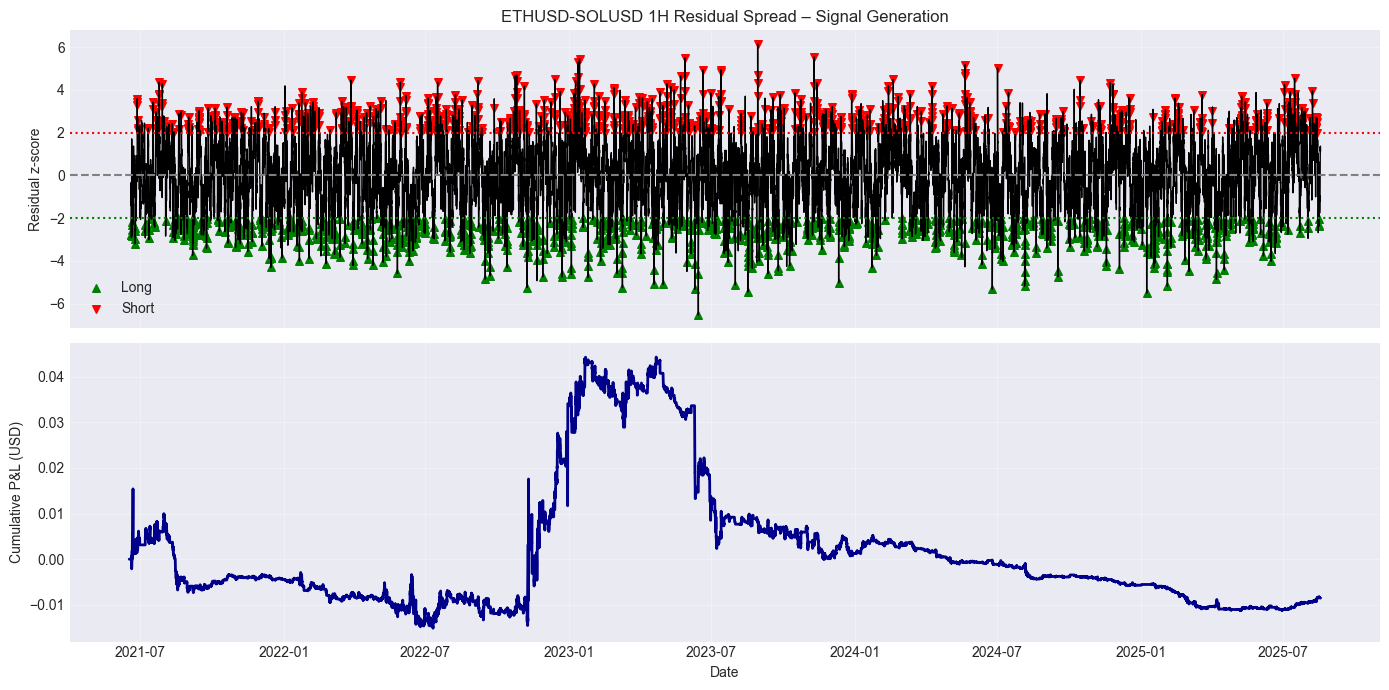

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------------
# 1. Grab the 1H residual spread & signals already computed in Cell 1
# ------------------------------------------------------------------
res1h   = analyzer.results['1H']          # shorthand
resSprd = res1h['traditional_results']['residual']   # residual spread dict
signals = res1h['signals']               # polars→pandas df with zscore, regimes, signals

# Convert to pandas if still polars
if hasattr(signals, 'to_pandas'):
    signals = signals.to_pandas()
signals['datetime'] = pd.to_datetime(res1h['timestamps'][:len(signals)])
signals.set_index('datetime', inplace=True)

# ETH & SOL 1H close prices (already aligned)
prices = pd.DataFrame({
    'ETHUSD': res1h['prices1'][:len(signals)],
    'SOLUSD': res1h['prices2'][:len(signals)]
}, index=signals.index)

# ------------------------------------------------------------------
# 2. Strategy parameters
# ------------------------------------------------------------------
ENTRY_Z  = 2.0          # z-score entry threshold
EXIT_Z   = 0.5          # z-score exit / take-profit
STOP_Z   = 3.0          # stop-loss z-score (optional)
VOL_FILTER = True       # only trade in medium + high volume regimes (1,2)

# ------------------------------------------------------------------
# 3. Generate clean signal columns
# ------------------------------------------------------------------
signals['z'] = signals['spread_zscore']
signals['regime'] = signals['volume_regime']

# Long when spread is very negative (buy ETH, short SOL)
# Short when spread is very positive (short ETH, buy SOL)
signals['long']  = (signals['z'] < -ENTRY_Z)
signals['short'] = (signals['z'] >  ENTRY_Z)

if VOL_FILTER:
    signals['long']  &= signals['regime'].isin([1,2])
    signals['short'] &= signals['regime'].isin([1,2])

signals['exit'] = (np.abs(signals['z']) < EXIT_Z) | (np.abs(signals['z']) > STOP_Z)

# ------------------------------------------------------------------
# 4. Position sizing: 1 USD nominal each leg (dollar-neutral)
# ------------------------------------------------------------------
def size_neutral(prc):
    """Return unit size so 1 USD nominal exposure."""
    return 1.0 / prc

signals['eth_units'] = 0.0
signals['sol_units'] = 0.0

in_pos = 0   # 0=flat, 1=long, -1=short
for i, row in signals.iterrows():
    if in_pos == 0:
        if row['long']:
            in_pos =  1
        elif row['short']:
            in_pos = -1
        else:
            in_pos =  0
    elif row['exit']:
        in_pos = 0
    
    if in_pos == 1:        # long ETH, short SOL
        signals.at[i, 'eth_units'] =  size_neutral(prices.loc[i, 'ETHUSD'])
        signals.at[i, 'sol_units'] = -size_neutral(prices.loc[i, 'SOLUSD'])
    elif in_pos == -1:     # short ETH, long SOL
        signals.at[i, 'eth_units'] = -size_neutral(prices.loc[i, 'ETHUSD'])
        signals.at[i, 'sol_units'] =  size_neutral(prices.loc[i, 'SOLUSD'])
    # else 0 → already 0

signals['position'] = in_pos   # final state (for plotting)

# ------------------------------------------------------------------
# 5. P&L calculation (per-period, in USD)
# ------------------------------------------------------------------
rets = prices.pct_change().fillna(0)
signals['pnl'] = signals['eth_units'].shift(1) * rets['ETHUSD'] + \
                 signals['sol_units'].shift(1) * rets['SOLUSD']

# Cumulative
signals['cum_pnl'] = signals['pnl'].cumsum()

# ------------------------------------------------------------------
# 6. Performance metrics
# ------------------------------------------------------------------
def sharpe(returns, freq=24*365):   # 1H → ~24*365 periods per year
    return returns.mean() / returns.std() * np.sqrt(freq)

def max_dd(cum):
    running_max = cum.cummax()
    drawdown = (cum - running_max) / running_max
    return drawdown.min()

ann_ret = signals['pnl'].mean() * 24*365
sharpe_ratio = sharpe(signals['pnl'])
max_drawdown = max_dd(signals['cum_pnl'])
num_trades = (signals['position'].diff().abs() > 0).sum()

print("--------------------------------------------------")
print("1H RESIDUAL SPREAD – RELATIVE VALUE BACK-TEST")
print("--------------------------------------------------")
print(f"Annualised return : {ann_ret:7.2%}")
print(f"Sharpe ratio      : {sharpe_ratio:7.2f}")
print(f"Max drawdown      : {max_drawdown:7.2%}")
print(f"Number of round trips: {num_trades}")
print("--------------------------------------------------")

# ------------------------------------------------------------------
# 7. Quick plot
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

# Top: spread z-score with entries/exits
ax[0].plot(signals.index, signals['z'], color='black', lw=1)
ax[0].axhline(0, color='gray', ls='--')
ax[0].axhline(ENTRY_Z, color='red', ls=':')
ax[0].axhline(-ENTRY_Z, color='green', ls=':')
ax[0].scatter(signals[signals['long']].index,  signals[signals['long']]['z'],
              marker='^', color='green', s=30, label='Long')
ax[0].scatter(signals[signals['short']].index, signals[signals['short']]['z'],
              marker='v', color='red',  s=30, label='Short')
ax[0].set_ylabel('Residual z-score')
ax[0].set_title('ETHUSD-SOLUSD 1H Residual Spread – Signal Generation')
ax[0].legend()
ax[0].grid(alpha=0.3)

# Bottom: cumulative P&L
ax[1].plot(signals.index, signals['cum_pnl'], color='darkblue', lw=2)
ax[1].set_ylabel('Cumulative P&L (USD)')
ax[1].set_xlabel('Date')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Parameter tuning

In [3]:
from itertools import product

# Define the parameter grid
entry_z_values = np.arange(1.0, 3.5, 0.5)
exit_z_values  = np.arange(0.1, 1.0, 0.2)
stop_z_values  = [None, 2.5, 3.0, 3.5, 4.0]
vol_filter_values = [True, False]

results = []

# Run grid search
for ENTRY_Z, EXIT_Z, STOP_Z, VOL_FILTER in product(entry_z_values, exit_z_values, stop_z_values, vol_filter_values):
    
    df = signals.copy()
    df['z'] = df['spread_zscore']
    df['regime'] = df['volume_regime']
    
    # Entry signals
    df['long']  = df['z'] < -ENTRY_Z
    df['short'] = df['z'] >  ENTRY_Z

    if VOL_FILTER:
        df['long']  &= df['regime'].isin([1,2])
        df['short'] &= df['regime'].isin([1,2])

    if STOP_Z is not None:
        df['exit'] = (np.abs(df['z']) < EXIT_Z) | (np.abs(df['z']) > STOP_Z)
    else:
        df['exit'] = (np.abs(df['z']) < EXIT_Z)

    df['eth_units'] = 0.0
    df['sol_units'] = 0.0

    in_pos = 0
    for i, row in df.iterrows():
        if in_pos == 0:
            if row['long']:
                in_pos =  1
            elif row['short']:
                in_pos = -1
        elif row['exit']:
            in_pos = 0
        
        if in_pos == 1:
            df.at[i, 'eth_units'] =  size_neutral(prices.loc[i, 'ETHUSD'])
            df.at[i, 'sol_units'] = -size_neutral(prices.loc[i, 'SOLUSD'])
        elif in_pos == -1:
            df.at[i, 'eth_units'] = -size_neutral(prices.loc[i, 'ETHUSD'])
            df.at[i, 'sol_units'] =  size_neutral(prices.loc[i, 'SOLUSD'])

    df['pnl'] = df['eth_units'].shift(1) * rets['ETHUSD'] + df['sol_units'].shift(1) * rets['SOLUSD']
    df['cum_pnl'] = df['pnl'].cumsum()

    ann_ret = df['pnl'].mean() * 24*365
    sr = sharpe(df['pnl'])
    dd = max_dd(df['cum_pnl'])
    trades = (df['eth_units'].diff().abs() > 0).sum()

    results.append({
        'ENTRY_Z': ENTRY_Z,
        'EXIT_Z': EXIT_Z,
        'STOP_Z': STOP_Z,
        'VOL_FILTER': VOL_FILTER,
        'Sharpe': sr,
        'AnnualReturn': ann_ret,
        'Drawdown': dd,
        'Trades': trades
    })

# Convert to DataFrame and sort by Sharpe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Sharpe', ascending=False)
results_df.head(10)


,ENTRY_Z,EXIT_Z,STOP_Z,VOL_FILTER,Sharpe,AnnualReturn,Drawdown,Trades
194,2.5,0.9,3.0,True,0.902885,0.018493,-2.348940,7455
196,2.5,0.9,3.5,True,0.829294,0.017671,-2.348940,8923
198,2.5,0.9,4.0,True,0.735107,0.015815,-2.348940,9372
193,2.5,0.9,2.5,False,0.665287,0.012220,-2.101091,7271
166,2.5,0.3,3.5,True,0.642545,0.015632,-4.201394,13930
195,2.5,0.9,3.0,False,0.641928,0.013747,-2.348940,10487
197,2.5,0.9,3.5,False,0.641024,0.014002,-2.348940,10958
168,2.5,0.3,4.0,True,0.631591,0.015501,-4.201394,14520
190,2.5,0.9,NaN,True,0.623981,0.013708,-2.348940,9605
192,2.5,0.9,2.5,True,0.616576,0.008417,-1.525605,4332


MULTI-PAIR CRYPTOCURRENCY COINTEGRATION STRATEGY OPTIMIZER

Symbols: BTCUSD, ETHUSD, SOLUSD, XRPUSD
Timeframes: 1H, 4H, 1D
Data directory: coinbase/5m
Initialized optimizer for 4 symbols
Will analyze 6 pairs: [('BTCUSD', 'ETHUSD'), ('BTCUSD', 'SOLUSD'), ('BTCUSD', 'XRPUSD'), ('ETHUSD', 'SOLUSD'), ('ETHUSD', 'XRPUSD'), ('SOLUSD', 'XRPUSD')]

ANALYZING ALL CRYPTOCURRENCY PAIRS



Analyzing pairs: 100%|██████████| 6/6 [01:23<00:00, 13.92s/it]



OPTIMIZING PARAMETERS FOR ALL PAIRS - TIMEFRAME: 1H



Optimizing pairs: 100%|██████████| 6/6 [1:10:33<00:00, 705.61s/it] 



✓ Optimization complete! Generated 250 strategy configurations

────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 10 STRATEGIES BY SHARPE RATIO:
────────────────────────────────────────────────────────────────────────────────────────────────────

         pair  sharpe_ratio  annual_return  max_drawdown  win_rate  num_trades  entry_z  exit_z  stop_z  vol_filter
ETHUSD_SOLUSD      0.902885       0.018493     -2.348940  0.508523        1408      2.5     0.9     3.0        True
ETHUSD_SOLUSD      0.829294       0.017671     -2.348940  0.516722        1196      2.5     0.9     3.5        True
ETHUSD_SOLUSD      0.735107       0.015815     -2.348940  0.500000        1076      2.5     0.9     4.0        True
ETHUSD_SOLUSD      0.665287       0.012220     -2.101091  0.498831        2566      2.5     0.9     2.5       False
ETHUSD_SOLUSD      0.642545       0.015632     -4.201394  0.510989        1092      2.5     0.3     3.5        True
E

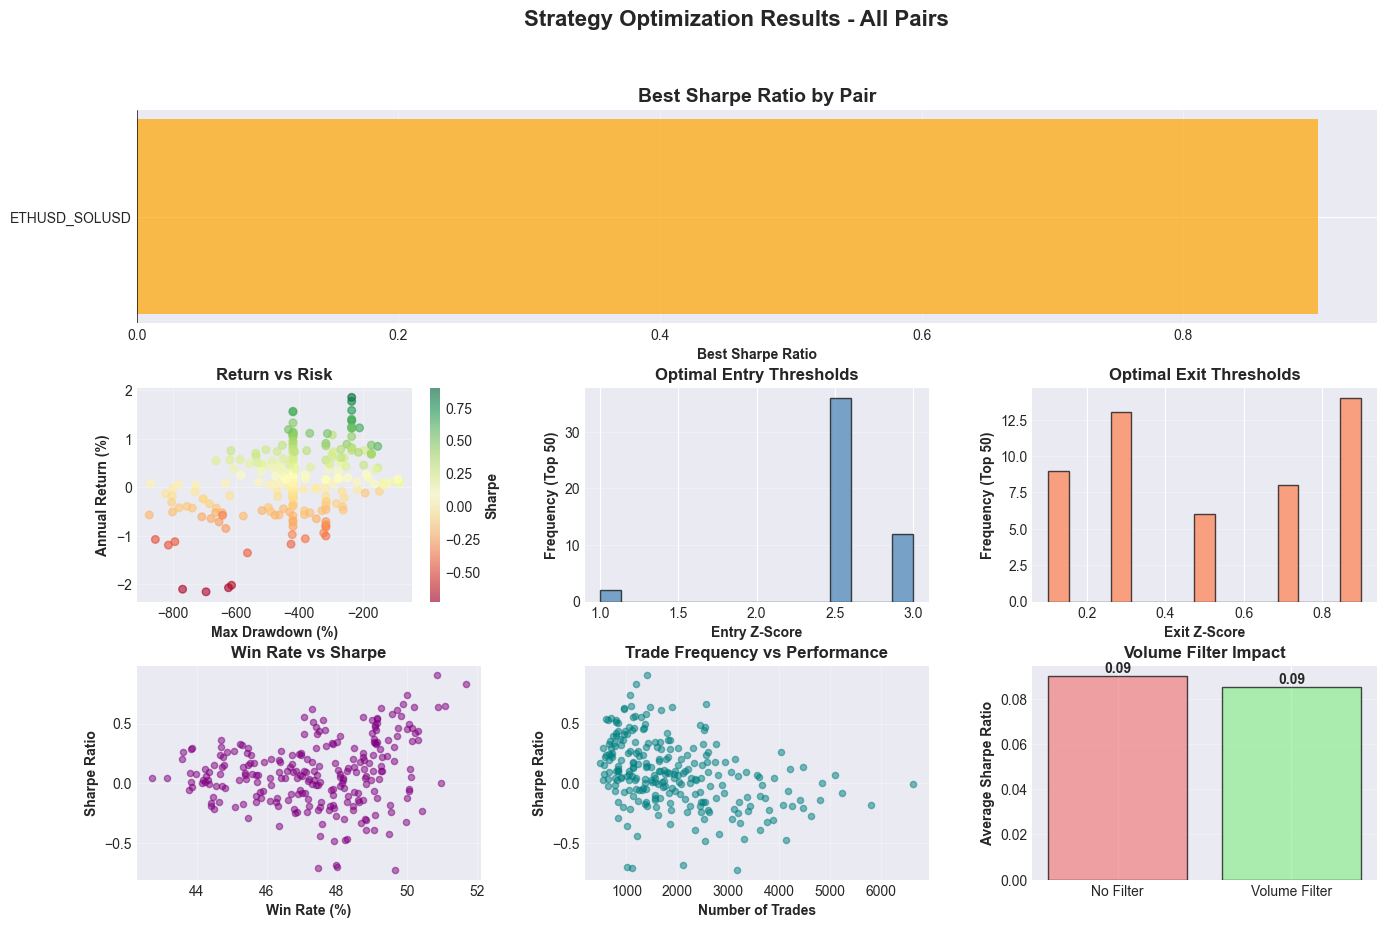

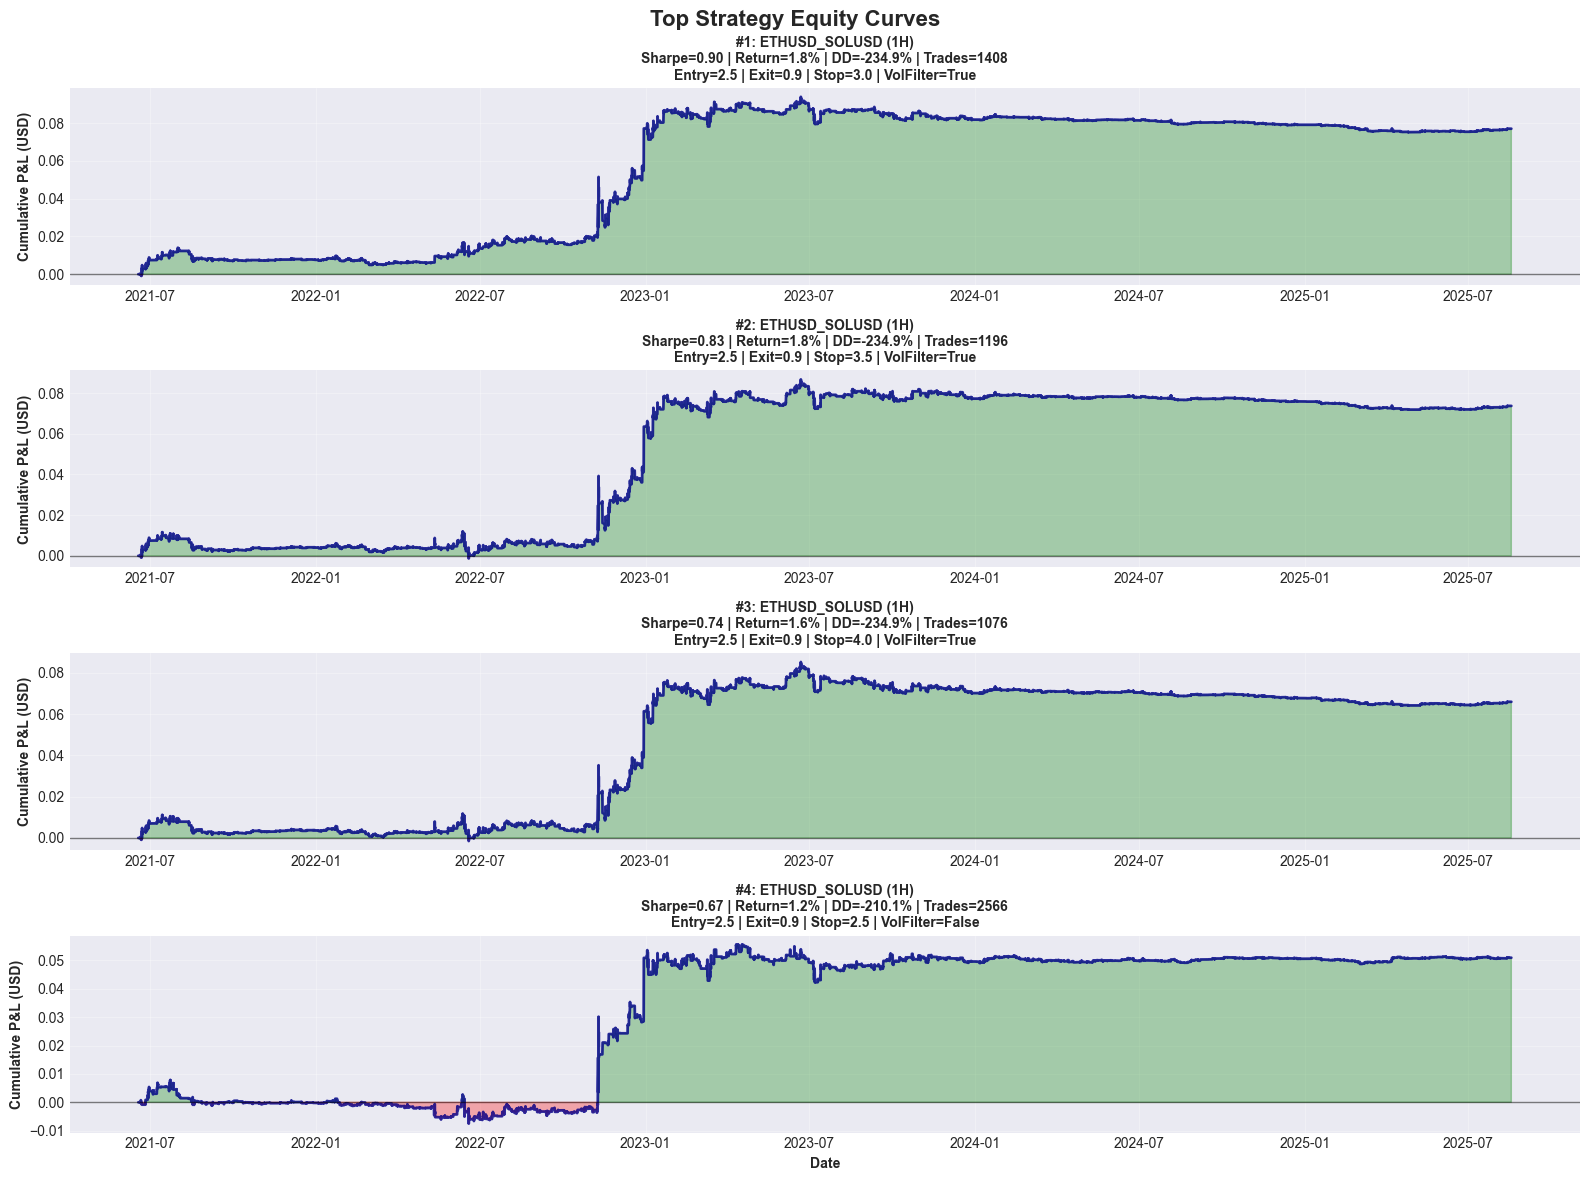


✓ Results exported to: optimization_results.csv

ANALYSIS COMPLETE



In [ ]:
"""
Complete Multi-Pair Cryptocurrency Cointegration Strategy with Parameter Optimization
Analyzes all possible pairs and optimizes trading parameters with full visualizations
"""

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import combinations, product
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


# ============================================================================
# PART 1: COINTEGRATION ANALYZER (Complete Implementation)
# ============================================================================

class CryptoCointegrationAnalyzer:
    """Generalized cointegration analyzer for any two cryptocurrency pairs."""
    
    def __init__(self, symbol1, symbol2, data_dir="coinbase/5m"):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.data_dir = Path(data_dir)
        self.data = {}
        self.results = {}
        
    def load_data(self):
        """Load and prepare data for both symbols."""
        csv_columns = ["timestamp", "open", "high", "low", "close", "volume"]
        
        for symbol in [self.symbol1, self.symbol2]:
            yearly_dfs = []
            
            for year_dir in sorted(self.data_dir.iterdir()):
                if not year_dir.is_dir():
                    continue
                    
                file_path = year_dir / f"{symbol}_5m_{year_dir.name}.csv"
                if file_path.exists():
                    df = pl.read_csv(file_path, has_header=False, new_columns=csv_columns)
                    
                    df_clean = df.filter(
                        pl.col("close").is_not_null() &
                        pl.col("volume").is_not_null() &
                        (pl.col("close") > 0) &
                        (pl.col("volume") >= 0) &
                        pl.col("close").is_finite() &
                        pl.col("volume").is_finite()
                    )
                    yearly_dfs.append(df_clean)
            
            if not yearly_dfs:
                raise ValueError(f"No data found for {symbol}")
            
            combined_df = pl.concat(yearly_dfs)
            combined_df = combined_df.with_columns(
                (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
            ).sort("datetime")
            
            combined_df = combined_df.unique(subset=["datetime"], keep="first")
            self.data[symbol] = combined_df
        
        return self
    
    def create_timeframe_aggregations(self, timeframes):
        """Aggregate 5-minute data to multiple timeframes."""
        self.timeframe_data = {}
        
        for tf_label, tf_freq in timeframes.items():
            sym1_agg = self.data[self.symbol1].group_by_dynamic("datetime", every=tf_freq).agg([
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume")
            ]).filter(pl.col("volume") > 0).sort("datetime")
            
            sym2_agg = self.data[self.symbol2].group_by_dynamic("datetime", every=tf_freq).agg([
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"), 
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume")
            ]).filter(pl.col("volume") > 0).sort("datetime")
            
            self.timeframe_data[tf_label] = {
                self.symbol1: sym1_agg, 
                self.symbol2: sym2_agg
            }
        
        return self
    
    def calculate_spread_formulations(self, prices1, prices2):
        """Calculate multiple spread formulations."""
        spreads = {}

        # Linear Spread
        range1 = np.ptp(prices1)
        range2 = np.ptp(prices2)
        scale_ratio = range1 / range2 if range2 > 0 else np.inf

        if scale_ratio < 10:
            spreads['linear'] = {
                'values': prices1 - prices2,
                'description': 'Linear Price Difference'
            }

        # Log Spread
        spreads['log'] = {
            'values': np.log(prices1) - np.log(prices2),
            'description': 'Log Price Difference'
        }

        # Ratio Spread
        spreads['ratio'] = {
            'values': prices1 / prices2,
            'description': 'Price Ratio'
        }

        # Residual-based spread (OLS)
        try:
            X = np.column_stack([np.ones(len(prices2)), prices2])
            coeffs = np.linalg.lstsq(X, prices1, rcond=None)[0]
            alpha, beta = coeffs[0], coeffs[1]
            residuals = prices1 - (alpha + beta * prices2)

            spreads['residual'] = {
                'values': residuals,
                'description': 'OLS Residual Spread',
                'beta': beta,
                'alpha': alpha
            }
        except Exception:
            pass

        return spreads
    
    def augmented_dickey_fuller_test(self, spread_values, significance_level=0.05):
        """Perform ADF test for stationarity."""
        try:
            adf_result = adfuller(spread_values, autolag='AIC', regression='c')
            adf_stat, p_value, lags, nobs, critical_values, ic_best = adf_result
            
            is_cointegrated = p_value < significance_level
            
            if adf_stat < critical_values['1%']:
                significance = "1%"
            elif adf_stat < critical_values['5%']:
                significance = "5%"
            elif adf_stat < critical_values['10%']:
                significance = "10%"
            else:
                significance = "None"
            
            return {
                'adf_statistic': adf_stat,
                'p_value': p_value,
                'lags_used': lags,
                'n_observations': nobs,
                'critical_values': critical_values,
                'is_cointegrated': is_cointegrated,
                'significance_achieved': significance
            }
        except Exception:
            return None
    
    def estimate_half_life(self, spread_values):
        """Estimate mean reversion half-life."""
        try:
            spread_changes = np.diff(spread_values)
            spread_lagged = spread_values[:-1]
            
            valid_mask = ~(np.isnan(spread_changes) | np.isnan(spread_lagged))
            if np.sum(valid_mask) < 20:
                return None
                
            y = spread_changes[valid_mask]
            X = np.column_stack([np.ones(np.sum(valid_mask)), spread_lagged[valid_mask]])
            
            coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
            beta = coeffs[1]
            
            if -2 < beta < 0:
                half_life = -np.log(2) / np.log(1 + beta)
                return half_life if 0 < half_life < 1000 else None
            
            return None
        except Exception:
            return None
    
    def detect_volume_regimes(self, volume_data, n_regimes=3):
        """Detect volume regimes using clustering."""
        volume_features = pd.DataFrame({
            'volume_level': volume_data,
            'volume_change': volume_data.pct_change(),
            'volume_ma_ratio': volume_data / volume_data.rolling(20).mean(),
        }).fillna(method='bfill')
        
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(volume_features)
        
        kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
        regimes = kmeans.fit_predict(features_scaled)
        
        cluster_means = volume_features.groupby(regimes)['volume_level'].mean()
        cluster_mapping = {old: new for new, old in enumerate(cluster_means.argsort())}
        regimes = pd.Series(regimes).map(cluster_mapping)
        
        return regimes.fillna(method='ffill')
    
    def analyze_timeframe(self, timeframe_label, min_observations=100):
        """Comprehensive analysis for a timeframe."""
        data1 = self.timeframe_data[timeframe_label][self.symbol1]
        data2 = self.timeframe_data[timeframe_label][self.symbol2]
        
        aligned = data1.join(data2, on="datetime", how="inner", suffix="_2")
        
        if aligned.height < min_observations:
            return {'error': 'Insufficient data', 'timeframe': timeframe_label}
        
        clean_aligned = aligned.filter(
            pl.col("close").is_not_null() &
            pl.col("close_2").is_not_null() &
            pl.col("volume").is_not_null() &
            pl.col("volume_2").is_not_null() &
            (pl.col("close") > 0) &
            (pl.col("close_2") > 0) &
            (pl.col("volume") >= 0) &
            (pl.col("volume_2") >= 0) &
            pl.col("close").is_finite() &
            pl.col("close_2").is_finite() &
            pl.col("volume").is_finite() &
            pl.col("volume_2").is_finite()
        )
        
        if clean_aligned.height < min_observations:
            return {'error': 'Insufficient clean data', 'timeframe': timeframe_label}
        
        timestamps = clean_aligned['datetime'].to_numpy()
        prices1 = clean_aligned['close'].to_numpy()
        prices2 = clean_aligned['close_2'].to_numpy()
        volume1 = clean_aligned['volume'].to_numpy()
        volume2 = clean_aligned['volume_2'].to_numpy()
        
        # Volume metrics
        df_for_volume = clean_aligned.to_pandas().set_index('datetime')
        total_volume = df_for_volume['volume'] + df_for_volume['volume_2']
        
        # Volume regimes
        volume_regimes = self.detect_volume_regimes(total_volume)
        
        # Ensure consistent lengths
        min_len = min(len(volume_regimes), len(prices1))
        volume_regimes = volume_regimes[:min_len]
        prices1 = prices1[:min_len]
        prices2 = prices2[:min_len]
        volume1 = volume1[:min_len]
        volume2 = volume2[:min_len]
        timestamps = timestamps[:min_len]
        
        # Traditional cointegration
        spreads = self.calculate_spread_formulations(prices1, prices2)
        traditional_results = {}
        
        for spread_name, spread_info in spreads.items():
            adf_result = self.augmented_dickey_fuller_test(spread_info['values'])
            if adf_result:
                half_life = self.estimate_half_life(spread_info['values'])
                traditional_results[spread_name] = {
                    **spread_info, 
                    **adf_result,
                    'half_life': half_life
                }
        
        # Generate signals DataFrame
        signals_df = None
        if traditional_results:
            best_spread = None
            for s in traditional_results:
                if traditional_results[s].get('is_cointegrated', False):
                    if best_spread is None or traditional_results[s]['p_value'] < traditional_results[best_spread]['p_value']:
                        best_spread = s
            
            if best_spread:
                spread_values = traditional_results[best_spread]['values']
                signals_df = pd.DataFrame({
                    'spread': spread_values,
                    'volume_regime': volume_regimes.values,
                })
                
                signals_df['spread_zscore'] = (
                    (signals_df['spread'] - signals_df['spread'].rolling(50).mean()) / 
                    signals_df['spread'].rolling(50).std()
                )
        
        return {
            'timeframe': timeframe_label,
            'n_observations': len(prices1),
            'timestamps': timestamps,
            'prices1': prices1,
            'prices2': prices2,
            'volume1': volume1,
            'volume2': volume2,
            'volume_regimes': volume_regimes,
            'traditional_results': traditional_results,
            'signals': signals_df
        }
    
    def run_analysis(self, timeframes_to_analyze=None):
        """Run full analysis across all timeframes."""
        if timeframes_to_analyze is None:
            timeframes_to_analyze = list(self.timeframe_data.keys())
        
        for tf_label in timeframes_to_analyze:
            if tf_label in self.timeframe_data:
                result = self.analyze_timeframe(tf_label)
                self.results[tf_label] = result
        
        return self.results


# ============================================================================
# PART 2: MULTI-PAIR STRATEGY OPTIMIZER
# ============================================================================

class MultiPairStrategyOptimizer:
    """Optimize cointegration strategies across multiple cryptocurrency pairs."""
    
    def __init__(self, symbols, data_dir="coinbase/5m"):
        self.symbols = symbols
        self.data_dir = Path(data_dir)
        self.pairs = list(combinations(symbols, 2))
        self.pair_results = {}
        self.optimization_results = []
        
        print(f"Initialized optimizer for {len(self.symbols)} symbols")
        print(f"Will analyze {len(self.pairs)} pairs: {self.pairs}")
    
    def analyze_all_pairs(self, timeframes):
        """Run cointegration analysis on all pairs."""
        print(f"\n{'='*80}")
        print(f"ANALYZING ALL CRYPTOCURRENCY PAIRS")
        print(f"{'='*80}\n")
        
        for sym1, sym2 in tqdm(self.pairs, desc="Analyzing pairs"):
            try:
                analyzer = CryptoCointegrationAnalyzer(sym1, sym2, self.data_dir)
                analyzer.load_data()
                analyzer.create_timeframe_aggregations(timeframes)
                results = analyzer.run_analysis()
                
                self.pair_results[f"{sym1}_{sym2}"] = {
                    'analyzer': analyzer,
                    'results': results
                }
            except Exception as e:
                print(f"\nError analyzing {sym1} vs {sym2}: {e}")
                continue
        
        return self
    
    @staticmethod
    def backtest_strategy(signals_df, prices1, prices2, 
                         entry_z, exit_z, stop_z, vol_filter):
        """
        Backtest a cointegration strategy with given parameters.
        Returns performance metrics.
        """
        df = signals_df.copy()
        
        # Entry signals
        df['long']  = df['spread_zscore'] < -entry_z
        df['short'] = df['spread_zscore'] >  entry_z
        
        if vol_filter:
            df['long']  &= df['volume_regime'].isin([1, 2])
            df['short'] &= df['volume_regime'].isin([1, 2])
        
        # Exit signals
        if stop_z is not None:
            df['exit'] = (np.abs(df['spread_zscore']) < exit_z) | (np.abs(df['spread_zscore']) > stop_z)
        else:
            df['exit'] = (np.abs(df['spread_zscore']) < exit_z)
        
        # Position tracking
        df['position'] = 0
        in_pos = 0
        
        for i in range(len(df)):
            if in_pos == 0:
                if df.iloc[i]['long']:
                    in_pos = 1
                elif df.iloc[i]['short']:
                    in_pos = -1
            elif df.iloc[i]['exit']:
                in_pos = 0
            
            df.iloc[i, df.columns.get_loc('position')] = in_pos
        
        # Calculate positions (dollar-neutral)
        def size_neutral(price):
            return 1.0 / price if price > 0 else 0
        
        prices_df = pd.DataFrame({'p1': prices1, 'p2': prices2}, index=df.index)
        
        df['units1'] = 0.0
        df['units2'] = 0.0
        
        long_mask = df['position'] == 1
        short_mask = df['position'] == -1
        
        df.loc[long_mask, 'units1'] = prices_df.loc[long_mask, 'p1'].apply(lambda x: size_neutral(x))
        df.loc[long_mask, 'units2'] = prices_df.loc[long_mask, 'p2'].apply(lambda x: -size_neutral(x))
        
        df.loc[short_mask, 'units1'] = prices_df.loc[short_mask, 'p1'].apply(lambda x: -size_neutral(x))
        df.loc[short_mask, 'units2'] = prices_df.loc[short_mask, 'p2'].apply(lambda x: size_neutral(x))
        
        # Calculate returns
        rets = prices_df.pct_change().fillna(0)
        df['pnl'] = df['units1'].shift(1) * rets['p1'] + df['units2'].shift(1) * rets['p2']
        df['cum_pnl'] = df['pnl'].cumsum()
        
        # Performance metrics
        periods_per_year = 24 * 365  # 1H data
        ann_ret = df['pnl'].mean() * periods_per_year
        sharpe = (df['pnl'].mean() / df['pnl'].std() * np.sqrt(periods_per_year)) if df['pnl'].std() > 0 else 0
        
        # Max drawdown
        running_max = df['cum_pnl'].cummax()
        drawdown = (df['cum_pnl'] - running_max) / running_max.replace(0, 1)
        max_dd = drawdown.min()
        
        # Number of trades
        num_trades = (df['position'].diff().abs() > 0).sum()
        
        # Win rate
        trade_returns = []
        entry_pnl = 0
        for i in range(1, len(df)):
            if df.iloc[i-1]['position'] == 0 and df.iloc[i]['position'] != 0:
                entry_pnl = df.iloc[i]['cum_pnl']
            elif df.iloc[i-1]['position'] != 0 and df.iloc[i]['position'] == 0:
                exit_pnl = df.iloc[i]['cum_pnl']
                trade_returns.append(exit_pnl - entry_pnl)
        
        win_rate = np.mean([1 if r > 0 else 0 for r in trade_returns]) if trade_returns else 0
        
        return {
            'annual_return': ann_ret,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'num_trades': num_trades,
            'win_rate': win_rate,
            'final_pnl': df['cum_pnl'].iloc[-1],
            'signals_df': df
        }
    
    def optimize_pair_parameters(self, pair_key, timeframe='1H',
                                entry_z_range=(1.0, 3.5, 0.5),
                                exit_z_range=(0.1, 1.0, 0.2),
                                stop_z_options=[None, 2.5, 3.0, 3.5, 4.0],
                                vol_filter_options=[True, False]):
        """
        Optimize strategy parameters for a specific pair.
        """
        if pair_key not in self.pair_results:
            return None
        
        result = self.pair_results[pair_key]['results'].get(timeframe)
        if not result or 'error' in result or result['signals'] is None:
            return None
        
        # Get data
        signals_df = result['signals'].copy()
        signals_df.index = pd.to_datetime(result['timestamps'][:len(signals_df)])
        
        prices1 = result['prices1'][:len(signals_df)]
        prices2 = result['prices2'][:len(signals_df)]
        
        # Parameter grid
        entry_zs = np.arange(*entry_z_range)
        exit_zs = np.arange(*exit_z_range)
        
        # Progress bar for parameter combinations
        total_combos = len(entry_zs) * len(exit_zs) * len(stop_z_options) * len(vol_filter_options)
        
        results = []
        pbar = tqdm(total=total_combos, desc=f"Optimizing {pair_key}", leave=False)
        
        for entry_z, exit_z, stop_z, vol_filter in product(entry_zs, exit_zs, stop_z_options, vol_filter_options):
            try:
                metrics = self.backtest_strategy(
                    signals_df, prices1, prices2,
                    entry_z, exit_z, stop_z, vol_filter
                )
                
                results.append({
                    'pair': pair_key,
                    'timeframe': timeframe,
                    'entry_z': entry_z,
                    'exit_z': exit_z,
                    'stop_z': stop_z,
                    'vol_filter': vol_filter,
                    **{k: v for k, v in metrics.items() if k != 'signals_df'}
                })
            except Exception:
                pass
            
            pbar.update(1)
        
        pbar.close()
        
        return pd.DataFrame(results)
    
    def optimize_all_pairs(self, timeframe='1H', **optimization_kwargs):
        """Run optimization across all pairs."""
        print(f"\n{'='*80}")
        print(f"OPTIMIZING PARAMETERS FOR ALL PAIRS - TIMEFRAME: {timeframe}")
        print(f"{'='*80}\n")
        
        all_results = []
        
        for pair_key in tqdm(self.pair_results.keys(), desc="Optimizing pairs"):
            opt_results = self.optimize_pair_parameters(
                pair_key, timeframe, **optimization_kwargs
            )
            
            if opt_results is not None and len(opt_results) > 0:
                all_results.append(opt_results)
        
        if all_results:
            self.optimization_results = pd.concat(all_results, ignore_index=True)
            return self.optimization_results
        else:
            print("No optimization results generated")
            return pd.DataFrame()
    
    def get_top_strategies(self, n=10, sort_by='sharpe_ratio'):
        """Get top N strategies ranked by performance metric."""
        if len(self.optimization_results) == 0:
            print("No optimization results available")
            return pd.DataFrame()
        
        return self.optimization_results.nlargest(n, sort_by)
    
    def plot_optimization_summary(self, figsize=(16, 10)):
        """Create comprehensive visualization of optimization results."""
        if len(self.optimization_results) == 0:
            print("No optimization results to plot")
            return
        
        df = self.optimization_results.copy()
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Best Sharpe by Pair
        ax1 = fig.add_subplot(gs[0, :])
        best_by_pair = df.loc[df.groupby('pair')['sharpe_ratio'].idxmax()]
        best_by_pair = best_by_pair.sort_values('sharpe_ratio', ascending=False)
        
        colors = ['green' if s > 1 else 'orange' if s > 0.5 else 'red' 
                 for s in best_by_pair['sharpe_ratio']]
        
        ax1.barh(range(len(best_by_pair)), best_by_pair['sharpe_ratio'], color=colors, alpha=0.7)
        ax1.set_yticks(range(len(best_by_pair)))
        ax1.set_yticklabels(best_by_pair['pair'])
        ax1.set_xlabel('Best Sharpe Ratio', fontweight='bold')
        ax1.set_title('Best Sharpe Ratio by Pair', fontweight='bold', fontsize=14)
        ax1.axvline(0, color='black', linestyle='-', linewidth=0.5)
        ax1.grid(True, alpha=0.3, axis='x')
        
        # 2. Return vs Risk scatter
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.scatter(df['max_drawdown']*100, df['annual_return']*100, 
                   c=df['sharpe_ratio'], cmap='RdYlGn', alpha=0.6, s=30)
        ax2.set_xlabel('Max Drawdown (%)', fontweight='bold')
        ax2.set_ylabel('Annual Return (%)', fontweight='bold')
        ax2.set_title('Return vs Risk', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        cbar = plt.colorbar(ax2.collections[0], ax=ax2)
        cbar.set_label('Sharpe', fontweight='bold')
        
        # 3. Parameter distributions (Entry Z)
        ax3 = fig.add_subplot(gs[1, 1])
        top_strategies = df.nlargest(50, 'sharpe_ratio')
        ax3.hist(top_strategies['entry_z'], bins=15, alpha=0.7, color='steelblue', edgecolor='black')
        ax3.set_xlabel('Entry Z-Score', fontweight='bold')
        ax3.set_ylabel('Frequency (Top 50)', fontweight='bold')
        ax3.set_title('Optimal Entry Thresholds', fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 4. Parameter distributions (Exit Z)
        ax4 = fig.add_subplot(gs[1, 2])
        ax4.hist(top_strategies['exit_z'], bins=15, alpha=0.7, color='coral', edgecolor='black')
        ax4.set_xlabel('Exit Z-Score', fontweight='bold')
        ax4.set_ylabel('Frequency (Top 50)', fontweight='bold')
        ax4.set_title('Optimal Exit Thresholds', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # 5. Win Rate vs Sharpe
        ax5 = fig.add_subplot(gs[2, 0])
        ax5.scatter(df['win_rate']*100, df['sharpe_ratio'], alpha=0.5, s=20, color='purple')
        ax5.set_xlabel('Win Rate (%)', fontweight='bold')
        ax5.set_ylabel('Sharpe Ratio', fontweight='bold')
        ax5.set_title('Win Rate vs Sharpe', fontweight='bold')
        ax5.grid(True, alpha=0.3)
        
        # 6. Trade Frequency
        ax6 = fig.add_subplot(gs[2, 1])
        ax6.scatter(df['num_trades'], df['sharpe_ratio'], alpha=0.5, s=20, color='teal')
        ax6.set_xlabel('Number of Trades', fontweight='bold')
        ax6.set_ylabel('Sharpe Ratio', fontweight='bold')
        ax6.set_title('Trade Frequency vs Performance', fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        # 7. Volume Filter Impact
        ax7 = fig.add_subplot(gs[2, 2])
        vol_filter_comparison = df.groupby('vol_filter')['sharpe_ratio'].mean()
        bars = ax7.bar(['No Filter', 'Volume Filter'], vol_filter_comparison.values, 
                      color=['lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
        ax7.set_ylabel('Average Sharpe Ratio', fontweight='bold')
        ax7.set_title('Volume Filter Impact', fontweight='bold')
        ax7.grid(True, alpha=0.3, axis='y')
        
        for bar in bars:
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.suptitle('Strategy Optimization Results - All Pairs', fontsize=16, fontweight='bold')
        plt.show()
    
    def plot_best_strategy_equity_curves(self, n_strategies=4, figsize=(16, 12)):
        """Plot equity curves for top N strategies."""
        if len(self.optimization_results) == 0:
            print("No optimization results to plot")
            return
        
        top_strats = self.optimization_results.nlargest(n_strategies, 'sharpe_ratio')
        
        fig, axes = plt.subplots(n_strategies, 1, figsize=figsize, sharex=False)
        if n_strategies == 1:
            axes = [axes]
        
        for idx, (_, strat) in enumerate(top_strats.iterrows()):
            pair_key = strat['pair']
            timeframe = strat['timeframe']
            
            # Get result and backtest
            result = self.pair_results[pair_key]['results'][timeframe]
            signals_df = result['signals'].copy()
            signals_df.index = pd.to_datetime(result['timestamps'][:len(signals_df)])
            
            prices1 = result['prices1'][:len(signals_df)]
            prices2 = result['prices2'][:len(signals_df)]
            
            backtest_result = self.backtest_strategy(
                signals_df, prices1, prices2,
                strat['entry_z'], strat['exit_z'], 
                strat['stop_z'], strat['vol_filter']
            )
            
            equity_curve = backtest_result['signals_df']['cum_pnl']
            
            ax = axes[idx]
            ax.plot(equity_curve.index, equity_curve.values, 
                   color='darkblue', linewidth=2, alpha=0.8)
            ax.fill_between(equity_curve.index, 0, equity_curve.values,
                           where=(equity_curve.values > 0), alpha=0.3, color='green')
            ax.fill_between(equity_curve.index, 0, equity_curve.values,
                           where=(equity_curve.values < 0), alpha=0.3, color='red')
            ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
            
            # Add annotations
            title = f"#{idx+1}: {pair_key} ({timeframe})"
            subtitle = (f"Sharpe={strat['sharpe_ratio']:.2f} | Return={strat['annual_return']*100:.1f}% | "
                       f"DD={strat['max_drawdown']*100:.1f}% | Trades={int(strat['num_trades'])}")
            params = (f"Entry={strat['entry_z']:.1f} | Exit={strat['exit_z']:.1f} | "
                     f"Stop={strat['stop_z'] if strat['stop_z'] else 'None'} | "
                     f"VolFilter={strat['vol_filter']}")
            
            ax.set_title(f"{title}\n{subtitle}\n{params}", fontweight='bold', fontsize=10)
            ax.set_ylabel('Cumulative P&L (USD)', fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            if idx == len(top_strats) - 1:
                ax.set_xlabel('Date', fontweight='bold')
        
        plt.suptitle('Top Strategy Equity Curves', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self):
        """Generate comprehensive text summary of optimization results."""
        if len(self.optimization_results) == 0:
            print("No optimization results available")
            return
        
        df = self.optimization_results
        
        print(f"\n{'='*100}")
        print(f"COMPREHENSIVE OPTIMIZATION SUMMARY")
        print(f"{'='*100}\n")
        
        # Overall statistics
        print(f"Total parameter combinations tested: {len(df):,}")
        print(f"Pairs analyzed: {df['pair'].nunique()}")
        print(f"Profitable strategies (Sharpe > 0): {len(df[df['sharpe_ratio'] > 0]):,} ({len(df[df['sharpe_ratio'] > 0])/len(df)*100:.1f}%)")
        print(f"Strong strategies (Sharpe > 1): {len(df[df['sharpe_ratio'] > 1]):,} ({len(df[df['sharpe_ratio'] > 1])/len(df)*100:.1f}%)")
        
        # Best overall strategy
        best = df.loc[df['sharpe_ratio'].idxmax()]
        print(f"\n{'─'*100}")
        print(f"BEST OVERALL STRATEGY:")
        print(f"{'─'*100}")
        print(f"  Pair: {best['pair']}")
        print(f"  Timeframe: {best['timeframe']}")
        print(f"  Sharpe Ratio: {best['sharpe_ratio']:.3f}")
        print(f"  Annual Return: {best['annual_return']*100:.2f}%")
        print(f"  Max Drawdown: {best['max_drawdown']*100:.2f}%")
        print(f"  Win Rate: {best['win_rate']*100:.1f}%")
        print(f"  Number of Trades: {int(best['num_trades'])}")
        print(f"  Parameters:")
        print(f"    - Entry Z: {best['entry_z']:.1f}")
        print(f"    - Exit Z: {best['exit_z']:.1f}")
        print(f"    - Stop Z: {best['stop_z'] if best['stop_z'] else 'None'}")
        print(f"    - Volume Filter: {best['vol_filter']}")
        
        # Top 5 by pair
        print(f"\n{'─'*100}")
        print(f"TOP STRATEGY BY EACH PAIR:")
        print(f"{'─'*100}")
        
        best_by_pair = df.loc[df.groupby('pair')['sharpe_ratio'].idxmax()].sort_values('sharpe_ratio', ascending=False)
        
        for idx, (_, row) in enumerate(best_by_pair.iterrows(), 1):
            print(f"\n{idx}. {row['pair']}")
            print(f"   Sharpe: {row['sharpe_ratio']:6.2f} | "
                  f"Return: {row['annual_return']*100:6.1f}% | "
                  f"DD: {row['max_drawdown']*100:5.1f}% | "
                  f"WinRate: {row['win_rate']*100:4.1f}% | "
                  f"Trades: {int(row['num_trades']):3d}")
            print(f"   Params: Entry={row['entry_z']:.1f}, Exit={row['exit_z']:.1f}, "
                  f"Stop={row['stop_z'] if row['stop_z'] else 'None'}, VolFilter={row['vol_filter']}")
        
        # Parameter analysis
        print(f"\n{'─'*100}")
        print(f"PARAMETER INSIGHTS (Top 50 strategies):")
        print(f"{'─'*100}")
        
        top50 = df.nlargest(50, 'sharpe_ratio')
        
        print(f"\nEntry Z-Score:")
        print(f"  Most common: {top50['entry_z'].mode().values[0]:.1f}")
        print(f"  Average: {top50['entry_z'].mean():.2f}")
        print(f"  Range: {top50['entry_z'].min():.1f} - {top50['entry_z'].max():.1f}")
        
        print(f"\nExit Z-Score:")
        print(f"  Most common: {top50['exit_z'].mode().values[0]:.1f}")
        print(f"  Average: {top50['exit_z'].mean():.2f}")
        print(f"  Range: {top50['exit_z'].min():.1f} - {top50['exit_z'].max():.1f}")
        
        print(f"\nStop Loss:")
        stop_dist = top50['stop_z'].value_counts()
        for stop_val, count in stop_dist.items():
            print(f"  {stop_val if stop_val else 'None'}: {count} times ({count/50*100:.0f}%)")
        
        print(f"\nVolume Filter:")
        vol_dist = top50['vol_filter'].value_counts()
        for vol_val, count in vol_dist.items():
            print(f"  {'Enabled' if vol_val else 'Disabled'}: {count} times ({count/50*100:.0f}%)")
        
        # Performance distribution
        print(f"\n{'─'*100}")
        print(f"PERFORMANCE DISTRIBUTION:")
        print(f"{'─'*100}")
        
        print(f"\nSharpe Ratio Distribution:")
        sharpe_bins = [(-np.inf, 0), (0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, np.inf)]
        for low, high in sharpe_bins:
            count = len(df[(df['sharpe_ratio'] > low) & (df['sharpe_ratio'] <= high)])
            pct = count / len(df) * 100
            label = f"{low:.1f} to {high:.1f}" if high != np.inf else f"> {low:.1f}"
            print(f"  {label:12s}: {count:5,} ({pct:5.1f}%)")
        
        print(f"\nAnnual Return Distribution:")
        ret_bins = [(-np.inf, -0.2), (-0.2, 0), (0, 0.2), (0.2, 0.5), (0.5, 1), (1, np.inf)]
        for low, high in ret_bins:
            count = len(df[(df['annual_return'] > low) & (df['annual_return'] <= high)])
            pct = count / len(df) * 100
            label = f"{low*100:.0f}% to {high*100:.0f}%" if high != np.inf else f"> {low*100:.0f}%"
            print(f"  {label:15s}: {count:5,} ({pct:5.1f}%)")
        
        print(f"\n{'='*100}\n")


# ============================================================================
# PART 3: MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    
    # Configuration
    SYMBOLS = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
    DATA_DIR = 'coinbase/5m'
    
    TIMEFRAMES = {
        '1H': '1h',
        '4H': '4h',
        '1D': '1d',
    }
    
    # Parameter ranges for optimization
    OPTIMIZATION_PARAMS = {
        'entry_z_range': (1.0, 3.5, 0.5),      # (start, stop, step)
        'exit_z_range': (0.1, 1.0, 0.2),
        'stop_z_options': [None, 2.5, 3.0, 3.5, 4.0],
        'vol_filter_options': [True, False]
    }
    
    print(f"{'='*100}")
    print(f"MULTI-PAIR CRYPTOCURRENCY COINTEGRATION STRATEGY OPTIMIZER")
    print(f"{'='*100}")
    print(f"\nSymbols: {', '.join(SYMBOLS)}")
    print(f"Timeframes: {', '.join(TIMEFRAMES.keys())}")
    print(f"Data directory: {DATA_DIR}")
    
    # Initialize optimizer
    optimizer = MultiPairStrategyOptimizer(SYMBOLS, DATA_DIR)
    
    # Step 1: Analyze all pairs for cointegration
    optimizer.analyze_all_pairs(TIMEFRAMES)
    
    # Step 2: Optimize parameters (focusing on 1H timeframe)
    optimization_results = optimizer.optimize_all_pairs(
        timeframe='1H',
        **OPTIMIZATION_PARAMS
    )
    
    # Step 3: Display results
    if len(optimization_results) > 0:
        print(f"\n✓ Optimization complete! Generated {len(optimization_results):,} strategy configurations")
        
        # Show top 10 strategies
        print(f"\n{'─'*100}")
        print(f"TOP 10 STRATEGIES BY SHARPE RATIO:")
        print(f"{'─'*100}\n")
        
        top10 = optimizer.get_top_strategies(n=10, sort_by='sharpe_ratio')
        print(top10[['pair', 'sharpe_ratio', 'annual_return', 'max_drawdown', 
                     'win_rate', 'num_trades', 'entry_z', 'exit_z', 'stop_z', 
                     'vol_filter']].to_string(index=False))
        
        # Generate comprehensive report
        optimizer.generate_summary_report()
        
        # Create visualizations
        print("\nGenerating visualizations...")
        optimizer.plot_optimization_summary()
        optimizer.plot_best_strategy_equity_curves(n_strategies=4)
        
        # Export results
        output_file = 'optimization_results.csv'
        optimization_results.to_csv(output_file, index=False)
        print(f"\n✓ Results exported to: {output_file}")
        
    else:
        print("\n✗ No optimization results generated. Check if pairs are cointegrated.")
    
    print(f"\n{'='*100}")
    print(f"ANALYSIS COMPLETE")
    print(f"{'='*100}\n")